EMBEDDING CON GLOVE:

START ED END AVANZANO E MIGLIORANO SEGUENDO PASSI PARAGONABILI TRA LORO

MIGLIOR RETE => ADDITIVE ATTENTION

#DATA 

###LOADING FROM SAVED PICKLE

In [ ]:
!git clone https://github.com/federicozanini/NLP.git

Cloning into 'NLP'...
remote: Enumerating objects: 118, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 118 (delta 10), reused 27 (delta 6), pack-reused 87
Receiving objects: 100% (118/118), 312.44 MiB | 31.45 MiB/s, done.
Resolving deltas: 100% (35/35), done.
Checking out files: 100% (34/34), done.


In [ ]:
import tensorflow as tf
import os
import numpy as np
import pandas as pd

In [ ]:
# LOADING DATA FROM OUR PICKLES

path = "./NLP/FINAL_DATASETS/VERSION_IDX_BY_WORD/{}.zip"

df_train = pd.read_pickle(path.format("df_train"), compression='zip')
df_val = pd.read_pickle(path.format("df_val"), compression='zip')

In [ ]:
# FAST LOOK TO THE TRAIN SET

print(df_train.shape)
df_train.head()

(65303, 10)


,id,title,context,question,text,context_list,question_list,answer_list,answer_start,answer_end
0,56f8f96c9e9bad19000a0796,Near_East,until the period following world war i the nea...,what was simpson s pen name,weale,"[until, the, period, following, world, war, i,...","[what, was, simpson, s, pen, name]",[weale],74,74
1,570e78860dc6ce19002050bd,Melbourne,melbourne s live performance institutions date...,from what year does the sidney myer music bowl...,1955,"[melbourne, s, live, performance, institutions...","[from, what, year, does, the, sidney, myer, mu...",[1955],114,114
2,56f8e48f9e9bad19000a06ac,Near_East,by the time of john seller s atlas maritima of...,when was john seller s atlas maritima,1670,"[by, the, time, of, john, seller, s, atlas, ma...","[when, was, john, seller, s, atlas, maritima]",[1670],10,10
3,57264659708984140094c11d,Greece,the following era was marked by instability as...,how many greek refugees came from turkey,15 million,"[the, following, era, was, marked, by, instabi...","[how, many, greek, refugees, came, from, turkey]","[15, million]",9,10
4,56d9ca63dc89441400fdb828,Dog,there have been two major trends in the changi...,when a person shapes a dog to conform to his e...,commodification,"[there, have, been, two, major, trends, in, th...","[when, a, person, shapes, a, dog, to, conform,...",[commodification],19,19


In [ ]:
# FAST LOOK TO THE VALIDATION 

print(df_val.shape)
df_val.head()

(12371, 10)


,id,title,context,question,text,context_list,question_list,answer_list,answer_start,answer_end
0,5730ee0ce6313a140071cac0,Bird,birds have wings which are more or less develo...,what makes birds uniquely adapted for flight,digestive and respiratory systems,"[birds, have, wings, which, are, more, or, les...","[what, makes, birds, uniquely, adapted, for, f...","[digestive, and, respiratory, systems]",58,61
1,572b6762be1ee31400cb8360,Guam,an infestation of the coconut rhinoceros beetl...,what other american territory has these beetle...,american samoa,"[an, infestation, of, the, coconut, rhinoceros...","[what, other, american, territory, has, these,...","[american, samoa]",30,31
2,57265974dd62a815002e8269,Intellectual_property,the growth of the internet and particularly di...,which articles of the eu copyright directive a...,article 6 and 7,"[the, growth, of, the, internet, and, particul...","[which, articles, of, the, eu, copyright, dire...","[article, 6, and, 7]",156,159
3,5706d85a2eaba6190074ad39,"Atlantic_City,_New_Jersey",executives at trump entertainment resorts whos...,why did executives say they were considering s...,winding down and exiting the gaming and hotel ...,"[executives, at, trump, entertainment, resorts...","[why, did, executives, say, they, were, consid...","[winding, down, and, exiting, the, gaming, and...",29,37
4,5726d8c15951b619008f7fcb,Queen_(band),the band have released a total of eighteen num...,how many number one dvd s has queen released,ten,"[the, band, have, released, a, total, of, eigh...","[how, many, number, one, dvd, s, has, queen, r...",[ten],16,16


## BUILDING VOCABULARIES

In [ ]:
from collections import OrderedDict
import itertools
from pandas.core.common import flatten

def build_vocabulary(df):
    corpus = list(flatten(df['question_list']))
    corpus += list(flatten(df['context_list'])) # contains answers' words too    
    
    # dropping repetitions
    corpus = set(corpus)

    idx_to_word = OrderedDict()
    idx_to_word[0] = 'PAD'
    word_to_idx = OrderedDict()
    word_to_idx['PAD'] = 0

    for i, el in enumerate(corpus):
        idx_to_word[i+1] = el
        word_to_idx[el] = i+1

    # to use for the test-set's out-of-train-vocabulary-set
    idx_oov = len(idx_to_word)
    idx_to_word[idx_oov] = 'OOV'
    word_to_idx['OOV'] = idx_oov

    return idx_to_word, word_to_idx

In [ ]:
# BUILDING UNIQUE VOCABULARY FOR TRAIN AND VALIDATION SETS

idx_to_word, word_to_idx = build_vocabulary(pd.concat([df_train, df_val]))

###saving vocabularies

In [ ]:
import json

# convert into JSON:
with open('idx_to_word.json', 'w') as outfile:
  json.dump(idx_to_word, outfile)
with open('word_to_idx.json', 'w') as outfile:
  json.dump(word_to_idx, outfile)

##ENCODING TRAIN SET (GENERATOR)

In [ ]:
# ENCODING OF THE TRAIN SET THROUGH A GENERATOR (OTHERWISE => RAM OVERFLOW):
    # CONTEXT_LIST => EACH ELEMENT ENCODED AS ITS VOCABULARY'S INDEX
    # QUESTION_LIST => EACH ELEMENT ENCODED AS ITS VOCABULARY'S INDEX
    # ANSWER_START => ONE-HOT-ENCODED OVER THE LENGTH OF CONTEXT_LIST
    # ANSWER_END => ONE-HOT-ENCODED OVER THE LENGTH OF CONTEXT_LIST

def load_data(df, batch_size):

    batch_counter = 0

    while True:
        # of a batch:
        contexts = []
        questions  = []
        answer_starts = []
        answer_ends = []
        # to select rows that go into a certain batch
        from_row = batch_counter*batch_size
        to_row = (batch_counter+1)*batch_size #NB IT DOES NOT BREAK IF INDEX OUT OF RANGE :)
        
        for i, row in df[from_row:to_row].iterrows():
        #COLUMN NAMES : question_list, context_list, answer_start, answer_end
            # QUESTIONS EMBEDDING
            question = []
            # formatting single question
            for word in row['question_list']:
                question.append(word_to_idx[word])
            # adding it to the questions' column
            questions.append(question)
            
            # CONTEXTS EMBEDDING
            context = []
            # formatting single context 
            for word in row['context_list']:
                context.append(word_to_idx[word])
            # adding it to the contexts' column
            contexts.append(context)

            # OUTPUTS EMBEDDING
            # formatting outputs (ONE HOT ENCODING)
            start = np.zeros(shape=(len(context),))
            start[row['answer_start']] = 1
            end  = np.zeros(shape=(len(context)))
            end[row['answer_end']] = 1
            # adding it to the outputs' columns
            answer_starts.append(start)
            answer_ends.append(end)

        
        contexts = tf.keras.preprocessing.sequence.pad_sequences(contexts, dtype="float32", padding="post")
        questions = tf.keras.preprocessing.sequence.pad_sequences(questions, dtype="float32", padding="post")
        answer_starts = tf.keras.preprocessing.sequence.pad_sequences(answer_starts, dtype="float32", padding="post")
        answer_ends = tf.keras.preprocessing.sequence.pad_sequences(answer_ends, dtype="float32", padding="post")
        
        if batch_counter < df.shape[0]//batch_size:
          batch_counter += 1
        else:
          batch_counter = 0


        yield  (questions, contexts), (answer_starts, answer_ends)

In [ ]:
# EXAMPLE OF GENERATOR FUNCTIONING OVER TRAIN SET
# example: shapes of generator's first sample 
prova = next(load_data(df_train, 10))
print()
print("QUESTION :", prova[0][0].shape)
print("CONTEXT :", prova[0][1].shape)
print("ANSWER START ONE HOT ENCODING :", prova[1][0].shape)
print("ANSWER END ONE HOT ENCODING :", prova[1][0].shape)

# example: encodings of generator's first sample 
print("\nencoding of a context\n", prova[0][1][1])
print("\nencoding of a question\n", prova[0][0][1])
print("\nencoding of an answer_start\n", prova[1][0][1])
print("\nencoding of an answer_end\n", prova[1][1][1])


QUESTION : (10, 20)
CONTEXT : (10, 142)
ANSWER START ONE HOT ENCODING : (10, 142)
ANSWER END ONE HOT ENCODING : (10, 142)

encoding of a context
 [70812. 45638. 24039. 31016. 65654. 38819. 60276. 19703. 56350. 77115.
 19703. 58374. 54466. 19703. 61805. 72692. 19703. 61510. 35956. 24802.
 49121. 19703. 58374. 45638. 35561. 33331. 72692. 24329. 78044. 13823.
 57397. 48701. 38819. 60276. 11463. 58379. 19703. 52163. 41331. 19703.
 29809. 72692. 77394. 72692. 31753. 71595. 45638. 72692. 55416. 72692.
   132. 72692. 74450. 19703. 78142. 72692. 19703. 70812. 39859. 46016.
 24802. 11625. 55198. 63530. 58379. 39859. 13617. 70812. 17797. 78044.
 19703.  7723. 72692. 16408. 37923. 19703. 14834. 74450. 19703. 12022.
 43154. 19703. 70812. 38956. 13617. 74450. 11625. 72692. 22920. 63530.
 77115. 19703. 53777. 17797. 78044. 19703. 39697. 74450. 31763. 31016.
 30727. 10260. 51104. 22819. 24802. 11625. 19703. 74993.  1232. 58063.
 23065. 17797. 55366. 60276. 32608. 55198. 22819. 24802. 19703. 18261.
 

##ENCODING VALIDATION SET

In [ ]:
# ENCODING OF THE VALIDATION SET (WHOLE SET AT ONE TIME)
    # CONTEXT_LIST => EACH ELEMENT ENCODED AS ITS VOCABULARY'S INDEX
    # QUESTION_LIST => EACH ELEMENT ENCODED AS ITS VOCABULARY'S INDEX
    # ANSWER_START => ONE-HOT-ENCODED OVER THE LENGTH OF CONTEXT_LIST
    # ANSWER_END => ONE-HOT-ENCODED OVER THE LENGTH OF CONTEXT_LIST

def encode_val(df):
    contexts = []
    questions  = []
    answer_starts = []
    answer_ends = []
    
    for i, row in df.iterrows():
    #COLUMN NAMES : question_list, context_list, answer_start, answer_end
        # QUESTIONS EMBEDDING
        question = []
        # formatting single question
        for word in row['question_list']:
            question.append(word_to_idx[word])
        # adding it to the questions' column
        questions.append(question)
        
        # CONTEXTS EMBEDDING
        context = []
        # formatting single context 
        for word in row['context_list']:
            context.append(word_to_idx[word])
        # adding it to the contexts' column
        contexts.append(context)

        # OUTPUTS EMBEDDING
        # formatting outputs (ONE HOT ENCODING)
        start = np.zeros(shape=(len(context),))
        start[row['answer_start']] = 1
        end  = np.zeros(shape=(len(context)))
        end[row['answer_end']] = 1
        # adding it to the outputs' columns
        answer_starts.append(start)
        answer_ends.append(end)

    
    contexts = tf.keras.preprocessing.sequence.pad_sequences(contexts, dtype="float32", padding="post")
    questions = tf.keras.preprocessing.sequence.pad_sequences(questions, dtype="float32", padding="post")
    answer_starts = tf.keras.preprocessing.sequence.pad_sequences(answer_starts, dtype="float32", padding="post")
    answer_ends = tf.keras.preprocessing.sequence.pad_sequences(answer_ends, dtype="float32", padding="post")

    return (questions, contexts), (answer_starts, answer_ends)

In [ ]:
df_valENC = encode_val(df_val)

In [ ]:
# EXAMPLE OF VALIDATION SET ENCODING
print("\nencoding of a context\n", df_valENC[0][1][1])
print("\nencoding of a question\n", df_valENC[0][0][1])
print("\nencoding of an answer_start\n", df_valENC[1][0][1])
print("\nencoding of an answer_end\n", df_valENC[1][1][1])


encoding of a context
 [63637. 48882. 77115. 19703. 21970. 53836. 36612. 50407. 42058. 53836.
 17194. 50209. 48232. 37103. 48232. 36256. 14929. 49860. 50407. 55198.
 17195. 29294. 58379.  2738. 24802. 19703. 13235. 68169. 39259. 24802.
 51110. 28826. 43294. 56806. 46454. 36256.  9638.  7241. 49860. 46051.
 57397. 19703. 48882. 17194. 16327. 58379. 51857. 70967. 74450. 73436.
 62233. 63637. 77306. 77115.  7511. 32456. 55031. 53710. 48691. 37103.
  6787. 77115. 74054.  2111. 67438. 33337. 48232. 32404. 70542. 36680.
 19703. 51857. 77306. 48232. 16340. 49179. 74450. 30381. 49346. 19703.
 33337. 58379.  2239. 17202. 55031. 49222. 48691. 48232. 16340.  7241.
  7511. 58933. 44545. 32931. 63466. 75867. 24802. 32404.  2232. 60276.
 32404. 29294. 53554. 77115. 50407. 48882. 50407. 55198. 41693. 58379.
 62564. 17606. 74450. 63403. 50415. 17606. 74450. 19703. 15861. 50045.
 41331. 38687. 60049. 30923. 28826. 51110. 28826. 58168. 11709. 19247.
  1773. 30907. 11709. 48897. 61066. 16432. 74450. 412

#MODELS' GENERAL UTILITIES

##GRAPH FUNCTION

In [ ]:
# NAMES OF THE METRICS FOR TRAIN SET (as they are) AND VALIDATION SET (with a the prefix "val_"):
    #loss
    #start_loss
    #end_loss
    #start_categorical_accuracy
    #end_categorical_accuracy

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
plt.style.use('seaborn-whitegrid')

def draw_graphs(history, logs_dir):

  epochs = len(history['loss'])
  x = np.arange(0, epochs) + 1

  # LOSS
  fig, ax1 = plt.subplots()
  ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
  plt.title("Training results: epoch vs loss")
  ax1.set_xlabel('epoch')
  ax1.set_ylabel('loss')
  ax1.plot(x, history['loss'])
  ax1.tick_params(axis='y')
  
  plt.show()
  plt.savefig(os.path.join(logs_dir, "loss.png"))

  # VALIDATION LOSS
  fig, ax1 = plt.subplots()
  ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
  plt.title("Training results: epoch vs VALIDATION loss")
  ax1.set_xlabel('epoch')
  ax1.set_ylabel('val_loss')
  ax1.plot(x, history['val_loss'])
  ax1.tick_params(axis='y')
  
  plt.show()
  plt.savefig(os.path.join(logs_dir, "val_loss.png"))

  # START CATEGORICAL ACCURACY
  fig, ax1 = plt.subplots()
  ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
  plt.title("Training results: epoch vs start_categorical_accuracy")
  ax1.set_xlabel('epoch')
  ax1.set_ylabel('start_categorical_accuracy')
  ax1.plot(x, history['start_categorical_accuracy'])
  ax1.tick_params(axis='y')

  plt.show()
  plt.savefig(os.path.join(logs_dir, "start_categorical_accuracy.png"))

  # VALIDATION START CATEGORICAL ACCURACY
  fig, ax1 = plt.subplots()
  ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
  plt.title("Training results: epoch vs VALIDATION start_categorical_accuracy")
  ax1.set_xlabel('epoch')
  ax1.set_ylabel('val_start_categorical_accuracy')
  ax1.plot(x, history['val_start_categorical_accuracy'])
  ax1.tick_params(axis='y')

  plt.show()
  plt.savefig(os.path.join(logs_dir, "val_start_categorical_accuracy.png"))

  # END CATEGORICAL ACCURACY
  fig, ax1 = plt.subplots()
  ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
  plt.title("Training results: epoch vs end_categorical_accuracy")
  ax1.set_xlabel('epoch')
  ax1.set_ylabel('end_categorical_accuracy')
  ax1.plot(x, history['end_categorical_accuracy'])
  ax1.tick_params(axis='y')
  
  plt.show()
  plt.savefig(os.path.join(logs_dir, "end_categorical_accuracy.png"))

  # VALIDATION END CATEGORICAL ACCURACY
  fig, ax1 = plt.subplots()
  ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
  plt.title("Training results: epoch vs VALIDATION end_categorical_accuracy")
  ax1.set_xlabel('epoch')
  ax1.set_ylabel('val_end_categorical_accuracy')
  ax1.plot(x, history['val_end_categorical_accuracy'])
  ax1.tick_params(axis='y')

  plt.show()
  plt.savefig(os.path.join(logs_dir, "val_end_categorical_accuracy.png"))

##TRAIN FUNCTION

In [ ]:
import shutil

# NAMES OF THE METRICS FOR TRAIN SET (as they are) AND VALIDATION SET (with a the prefix "val_"):
    #loss
    #start_loss
    #end_loss
    #start_categorical_accuracy
    #end_categorical_accuracy

def train_model(folder, model, model_name, train_data, val_data, batch, epochs):
  
  # Path where the final model will be saved
  models_dir = os.path.join(folder, 'models')
  os.makedirs(models_dir, exist_ok = True)
  model_file = os.path.join(models_dir, model_name+".h5")
  
  # Path where the logs will be saved
  logs_dir = os.path.join('./logs', model_name)
  shutil.rmtree(logs_dir, ignore_errors=True)
  os.makedirs(logs_dir, exist_ok = True) 

  log_file = os.path.join(logs_dir, "training_logs.csv")
  
  # Plot the model structure
  model_image_file = os.path.join(logs_dir, model_name+'.png')
  tf.keras.utils.plot_model(model, to_file=model_image_file, show_shapes=True, show_layer_names=True)

  model_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=model_file,
    save_weights_only=False,
    save_best_only=True,
    monitor='val_loss', 
    mode='auto', 
    verbose=1, 
    )
  
  early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    restore_best_weights=True, 
    patience=8,
    monitor='val_loss',
    mode='auto', 
    verbose=1
    )
  
  reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
      monitor='val_loss',
      mode='auto',
      factor=0.5,
      patience=2,
      min_lr=0.001,
      verbose=1
      )
 
  history = model.fit(train_data,
    validation_data=val_data,
    epochs=epochs,
    steps_per_epoch = len(df_train)//batch,
    callbacks=[model_callback, early_stopping_callback, reduce_lr_callback]
    )

  draw_graphs(history.history, logs_dir)

  return history

#MODEL1
MODELS SPECIAL CHARACTERISTICS:
- REDUCING LEARNING RATE ACTIVATED
- EMBEDDING DIMENSION 100
- BATCH SIZE 256

##PARAMETERS

In [ ]:
#### Parameters :

# EMBEDDING DIMENSION
emb_dimension = 100

# BATCH SIZE
btch_size = 256 #choose 2 to the power of 6-9 and fitting the gpu ram

# LEARNING RATE
lrn_rate = 0.01

# NUMBER OF EPOCHS
n_epochs = 100

# RNN UNITS
rnn_units = 50

#################

##EMBEDDING PREPARATION

In [ ]:
# DOWLOADING GLOVE MODEL

import gensim
import gensim.downloader as gloader

download_path = "glove-wiki-gigaword-{}".format(emb_dimension)
try:
    glove_emb_model = gloader.load(download_path)
except ValueError as e:
    print("Invalid embedding model name! Check the embedding dimension:")
    print("Glove: 50, 100, 200, 300")
    raise e

[==================================================] 100.0% 128.1/128.1MB downloaded


In [ ]:
# CREATE EMBEDDING MATRIX ACCORDINGLY WITH THE INDEXES OF THE VOCABULARY:
    # at a certain row of the matrix,
    # we find the embedding for the word that has the same vocabulary's index.
    # if a word has no glove embedding it is matched with a random embedding
    # padding words are embedded as a zero-vector

def emb_matrix(voc_word_to_idx, embedding_model):
    # Prepare embedding matrix
    embedding_matrix = np.zeros((len(voc_word_to_idx), emb_dimension))
    misses = 0

    for word, i in voc_word_to_idx.items():
        # pad embedding
        if word=='PAD':
            ; # all zeros
        # oov embeddin
        elif word=='OOV':
            ; # all zeros
        # others embedding
        else:
          try:
              embedding_matrix[i] = embedding_model.get_vector(word)
          except Exception as e:
              embedding_matrix[i] = np.random.rand(emb_dimension,)
              misses += 1

    print("Converted {} words ({} ({:.2f}%) with no proper match)".format(len(voc_word_to_idx), misses, misses/len(voc_word_to_idx)))
    return embedding_matrix


emb_matrix = emb_matrix(word_to_idx, glove_emb_model)

Converted 78617 words (17530 (0.22%) with no proper match)


In [ ]:
# DEFINE THIS MODEL'S EMBEDDING LAYER

from tensorflow.keras.layers import Embedding

embedding_layer = Embedding(
    len(word_to_idx),
    emb_dimension,
    embeddings_initializer=tf.keras.initializers.Constant(emb_matrix),
    trainable=False,
)

## MODEL1 : ATTENTION

###BUILD

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Bidirectional, Attention, Flatten, Softmax

def build_model(rnn_units, learning_rate):
  # CONTEXT
  context_inputs = Input(shape=(None,), name='context_input')
  embedded_contexts = embedding_layer(context_inputs)
  bi_context = Bidirectional(LSTM(rnn_units, return_sequences=True), name='bi_context', merge_mode = 'sum')
  context_emb = bi_context(embedded_contexts)

  # QUESTION
  question_inputs = Input(shape=(None,), name='question_input')
  embedded_questions = embedding_layer(question_inputs)
  bi_question = Bidirectional(LSTM(rnn_units, return_sequences = True), name='bi_question', merge_mode = 'sum')
  question_emb = bi_question(embedded_questions)

  # ATTENTION
  att = Attention()([context_emb, question_emb])
  
  # FURTHER ELABORATION
  modelling_layer = Bidirectional(LSTM(rnn_units, return_sequences=True), name='modelling_layer', merge_mode = 'sum')(att)

  # START
  start = Dense(64, activation='relu', name='start0')(modelling_layer)
  start = Dense(1, activation='relu', name='start1')(start)
  start = Flatten(name='flatten_start')(start)
  out_start = Softmax(name='start')(start)

  # END
  end = Dense(64, activation='relu', name='end0')(modelling_layer)
  end = Dense(1, activation='relu', name='end1')(end)
  end = Flatten(name='flatten_end')(end)
  out_end = Softmax(name='end')(end)

  # LOSS FUNCTION, ACCURACY and OPTIMIZER DEFINITION
  loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False, name='categorical_crossentropy')
  accuracy = tf.keras.metrics.CategoricalAccuracy(name='categorical_accuracy', dtype=None)
  opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
  
  model = Model([question_inputs, context_inputs], [out_start, out_end])
  model.compile(optimizer=opt, loss=loss, metrics=accuracy)

  return model

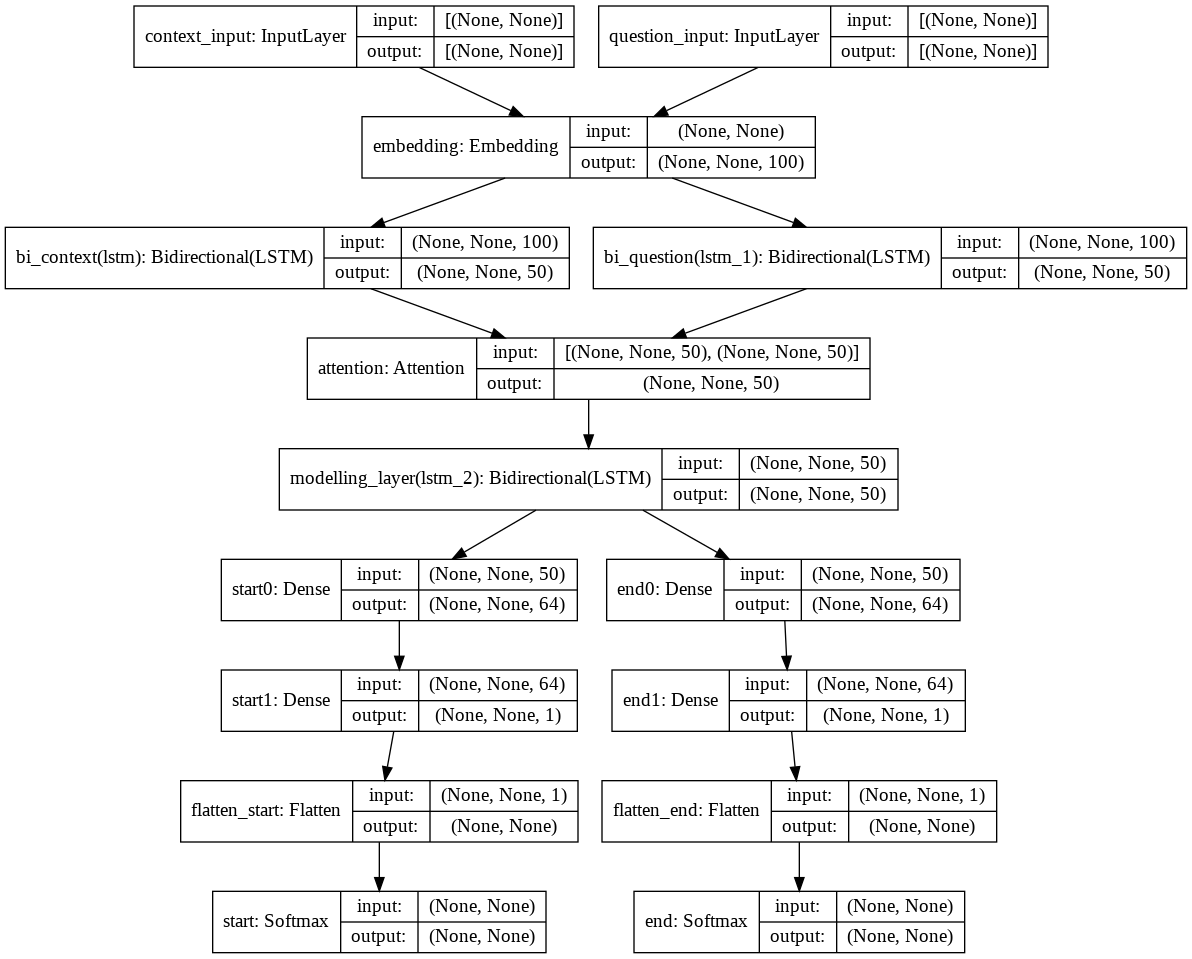

In [ ]:
model = build_model(rnn_units, lrn_rate)
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
context_input (InputLayer)      [(None, None)]       0                                            
__________________________________________________________________________________________________
question_input (InputLayer)     [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 100)    7861700     context_input[0][0]              
                                                                 question_input[0][0]             
__________________________________________________________________________________________________
bi_context (Bidirectional)      (None, None, 50)     60400       embedding[0][0]              

###TRAIN

Epoch 1/100
255/255 [==============================] - 71s 194ms/step - loss: 7.9000 - start_loss: 4.0500 - end_loss: 3.8500 - start_categorical_accuracy: 0.1069 - end_categorical_accuracy: 0.1131 - val_loss: 6.1724 - val_start_loss: 3.2297 - val_end_loss: 2.9427 - val_start_categorical_accuracy: 0.2188 - val_end_categorical_accuracy: 0.2340

Epoch 00001: val_loss improved from inf to 6.17242, saving model to ./models/models/model1_attention.h5
Epoch 2/100
255/255 [==============================] - 47s 186ms/step - loss: 6.0062 - start_loss: 3.1268 - end_loss: 2.8794 - start_categorical_accuracy: 0.2287 - end_categorical_accuracy: 0.2405 - val_loss: 5.7748 - val_start_loss: 3.0185 - val_end_loss: 2.7562 - val_start_categorical_accuracy: 0.2537 - val_end_categorical_accuracy: 0.2668

Epoch 00002: val_loss improved from 6.17242 to 5.77477, saving model to ./models/models/model1_attention.h5
Epoch 3/100
255/255 [==============================] - 47s 186ms/step - loss: 5.5969 - start_loss:

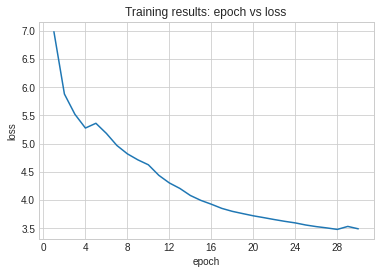

<Figure size 432x288 with 0 Axes>

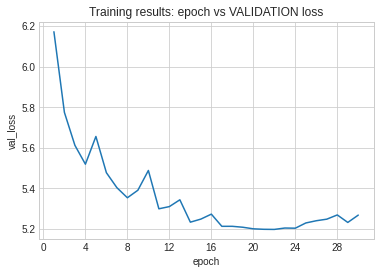

<Figure size 432x288 with 0 Axes>

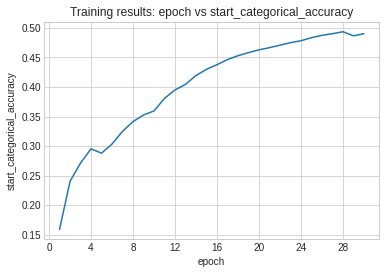

<Figure size 432x288 with 0 Axes>

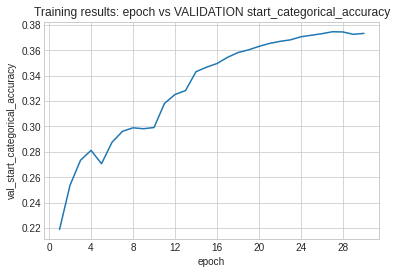

<Figure size 432x288 with 0 Axes>

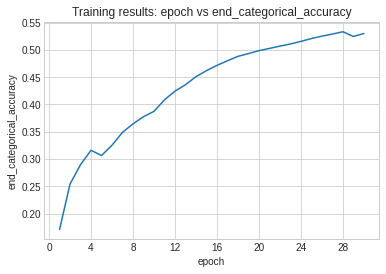

<Figure size 432x288 with 0 Axes>

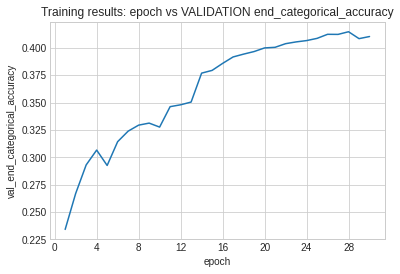

<Figure size 432x288 with 0 Axes>

In [ ]:
model_name = "model1_attention"

history = train_model(folder="./models", model=model, model_name=model_name,
                            train_data=load_data(df_train, btch_size), val_data=df_valENC, batch=btch_size, epochs=n_epochs)

###SAVING MODEL

In [ ]:
names_to_models1 = {}

In [ ]:
model_file = os.path.join('./models/models', model_name+'.h5')
model_bestweights = tf.keras.models.load_model(model_file)

names_to_models1[model_name] = (model_bestweights, history.history)

## MODEL1 : MULTIHEAD ATTENTION

###BUILD

In [ ]:
from tensorflow.keras.layers import MultiHeadAttention

def build_model(rnn_units, learning_rate):
  # CONTEXT
  context_inputs = Input(shape=(None,), name='context_input')
  embedded_contexts = embedding_layer(context_inputs)
  bi_context = Bidirectional(LSTM(rnn_units, return_sequences=True), name='bi_context', merge_mode = 'sum')
  context_emb = bi_context(embedded_contexts)

  # QUESTION
  question_inputs = Input(shape=(None,), name='question_input')
  embedded_questions = embedding_layer(question_inputs)
  bi_question = Bidirectional(LSTM(rnn_units, return_sequences = True), name='bi_question', merge_mode = 'sum')
  question_emb = bi_question(embedded_questions)

  # MULTIHEAD ATTENTION
  att = tf.keras.layers.MultiHeadAttention(4, key_dim=1,)(query=context_emb, value=question_emb, return_attention_scores=False)

  # FURTHER ELABORATION
  modelling_layer = Bidirectional(LSTM(rnn_units, return_sequences=True), name='modelling_layer', merge_mode = 'sum')(att)
  
  # START
  start = Dense(64, activation='relu', name='start0')(modelling_layer)
  start = Dense(1, activation='relu', name='start1')(start)
  start = Flatten(name='flatten_start')(start)
  out_start = Softmax(name='start')(start)

  # END
  end = Dense(64, activation='relu', name='end0')(modelling_layer)
  end = Dense(1, activation='relu', name='end1')(end)
  end = Flatten(name='flatten_end')(end)
  out_end = Softmax(name='end')(end)

  # LOSS FUNCTION, ACCURACY and OPTIMIZER DEFINITION
  loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False, name='categorical_crossentropy') #from_logits a True se non e' classification
  accuracy = tf.keras.metrics.CategoricalAccuracy(name='categorical_accuracy', dtype=None)
  opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
  
  model = Model([question_inputs, context_inputs], [out_start, out_end])
  model.compile(optimizer=opt, loss=loss, metrics=accuracy)

  return model

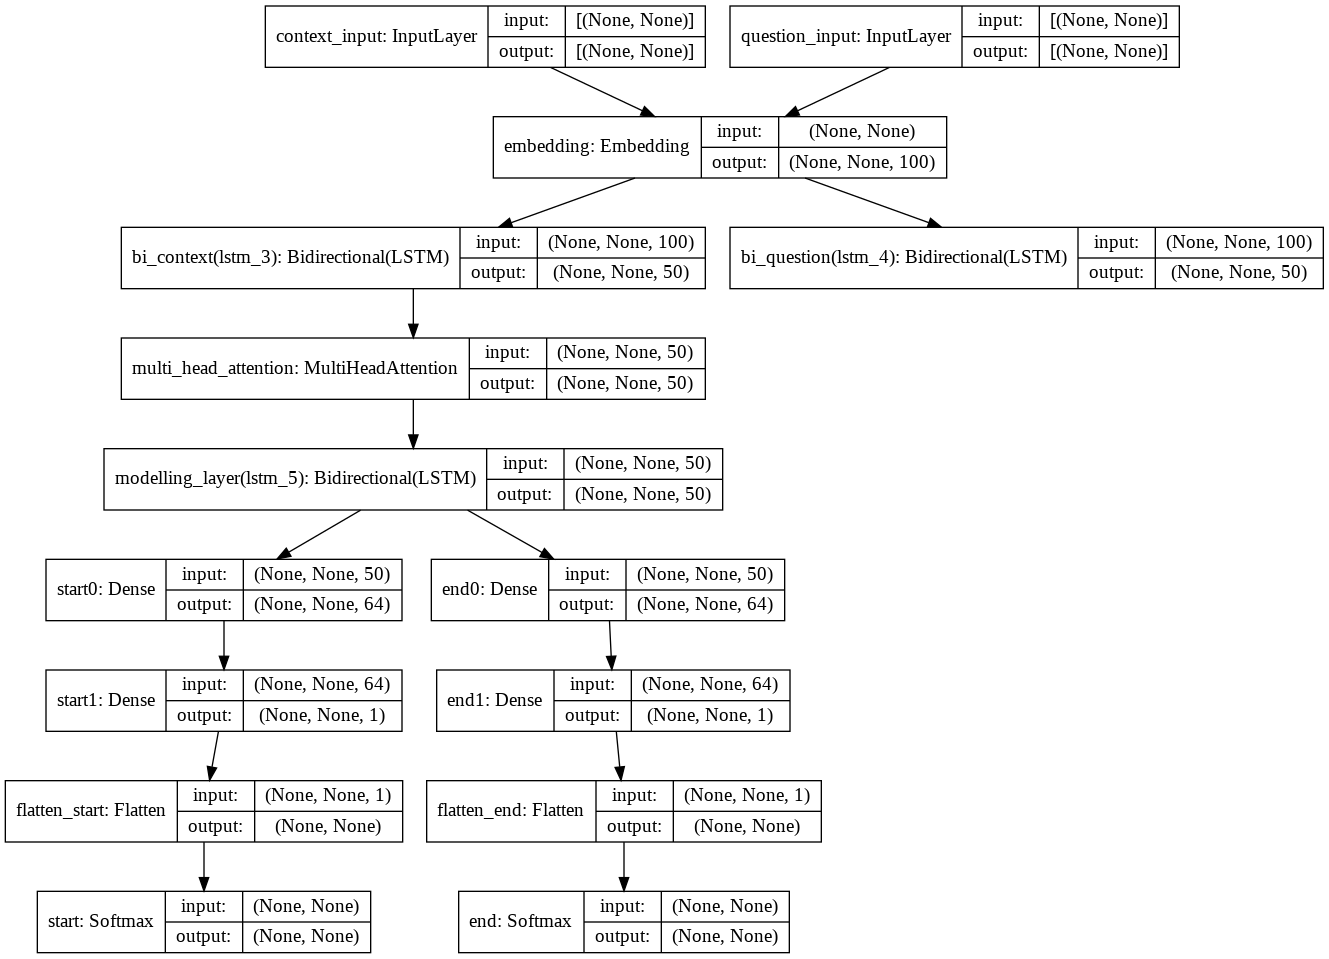

In [ ]:
model = build_model(rnn_units, lrn_rate)
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
context_input (InputLayer)      [(None, None)]       0                                            
__________________________________________________________________________________________________
question_input (InputLayer)     [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 100)    7861700     context_input[0][0]              
                                                                 question_input[0][0]             
__________________________________________________________________________________________________
bi_context (Bidirectional)      (None, None, 50)     60400       embedding[2][0]            

###TRAIN

Epoch 1/100
255/255 [==============================] - 58s 197ms/step - loss: 8.5199 - start_loss: 4.3486 - end_loss: 4.1713 - start_categorical_accuracy: 0.0710 - end_categorical_accuracy: 0.0729 - val_loss: 6.7342 - val_start_loss: 3.5241 - val_end_loss: 3.2102 - val_start_categorical_accuracy: 0.1610 - val_end_categorical_accuracy: 0.1807

Epoch 00001: val_loss improved from inf to 6.73422, saving model to ./models/models/model1_multiheadattention.h5
Epoch 2/100
255/255 [==============================] - 49s 191ms/step - loss: 6.5596 - start_loss: 3.4182 - end_loss: 3.1414 - start_categorical_accuracy: 0.1743 - end_categorical_accuracy: 0.1892 - val_loss: 6.3447 - val_start_loss: 3.3243 - val_end_loss: 3.0205 - val_start_categorical_accuracy: 0.1965 - val_end_categorical_accuracy: 0.2144

Epoch 00002: val_loss improved from 6.73422 to 6.34472, saving model to ./models/models/model1_multiheadattention.h5
Epoch 3/100
255/255 [==============================] - 49s 190ms/step - loss: 6.

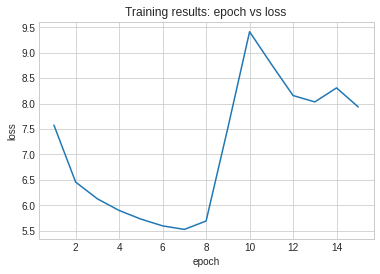

<Figure size 432x288 with 0 Axes>

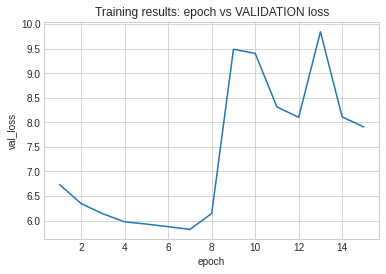

<Figure size 432x288 with 0 Axes>

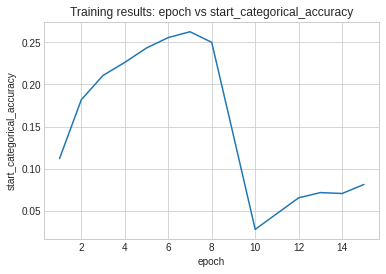

<Figure size 432x288 with 0 Axes>

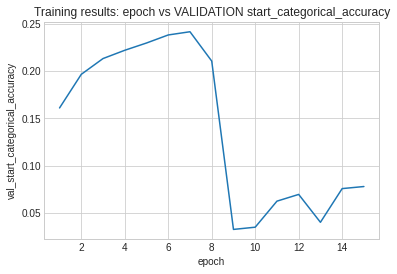

<Figure size 432x288 with 0 Axes>

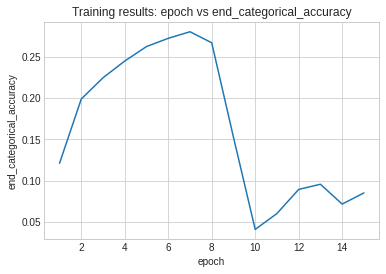

<Figure size 432x288 with 0 Axes>

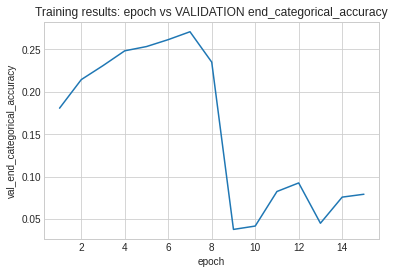

<Figure size 432x288 with 0 Axes>

In [ ]:
model_name = "model1_multiheadattention"

history = train_model(folder="./models", model=model, model_name=model_name,
                            train_data=load_data(df_train, btch_size), val_data=df_valENC, batch=btch_size, epochs=n_epochs)

###SAVING MODEL

In [ ]:
model_file = os.path.join('./models/models', model_name+'.h5')
model_bestweights = tf.keras.models.load_model(model_file)

names_to_models1[model_name] = (model_bestweights, history.history)

## MODEL1 : ADDITIVE ATTENTION

###BUILD

In [ ]:
from tensorflow.keras.layers import AdditiveAttention

def build_model(rnn_units, learning_rate):
  # CONTEXT
  context_inputs = Input(shape=(None,), name='context_input')
  embedded_contexts = embedding_layer(context_inputs)
  bi_context = Bidirectional(LSTM(rnn_units, return_sequences=True), name='bi_context', merge_mode = 'sum')
  context_emb = bi_context(embedded_contexts)
  
  # QUESTION
  question_inputs = Input(shape=(None,), name='question_input')
  embedded_questions = embedding_layer(question_inputs)
  bi_question = Bidirectional(LSTM(rnn_units, return_sequences = True), name='bi_question', merge_mode = 'sum')
  question_emb = bi_question(embedded_questions)

  # ADDITIVE ATTENTION
  att = AdditiveAttention()([context_emb, question_emb])

  # FURTHER ELABORATION
  modelling_layer = Bidirectional(LSTM(rnn_units, return_sequences=True), name='modelling_layer', merge_mode = 'sum')(att)

  # START
  start = Dense(64, activation='relu', name='start0')(modelling_layer)
  start = Dense(1, activation='relu', name='start1')(start)
  start = Flatten(name='flatten_start')(start)
  out_start = Softmax(name='start')(start)

  # END
  end = Dense(64, activation='relu', name='end0')(modelling_layer)
  end = Dense(1, activation='relu', name='end1')(end)
  end = Flatten(name='flatten_end')(end)
  out_end = Softmax(name='end')(end)

  # LOSS FUNCTION, ACCURACY and OPTIMIZER DEFINITION
  loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False, name='categorical_crossentropy') #from_logits a True se non e' classification
  accuracy = tf.keras.metrics.CategoricalAccuracy(name='categorical_accuracy', dtype=None)
  opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)

  model = Model([question_inputs, context_inputs], [out_start, out_end])
  model.compile(optimizer=opt, loss=loss, metrics=accuracy)

  return model

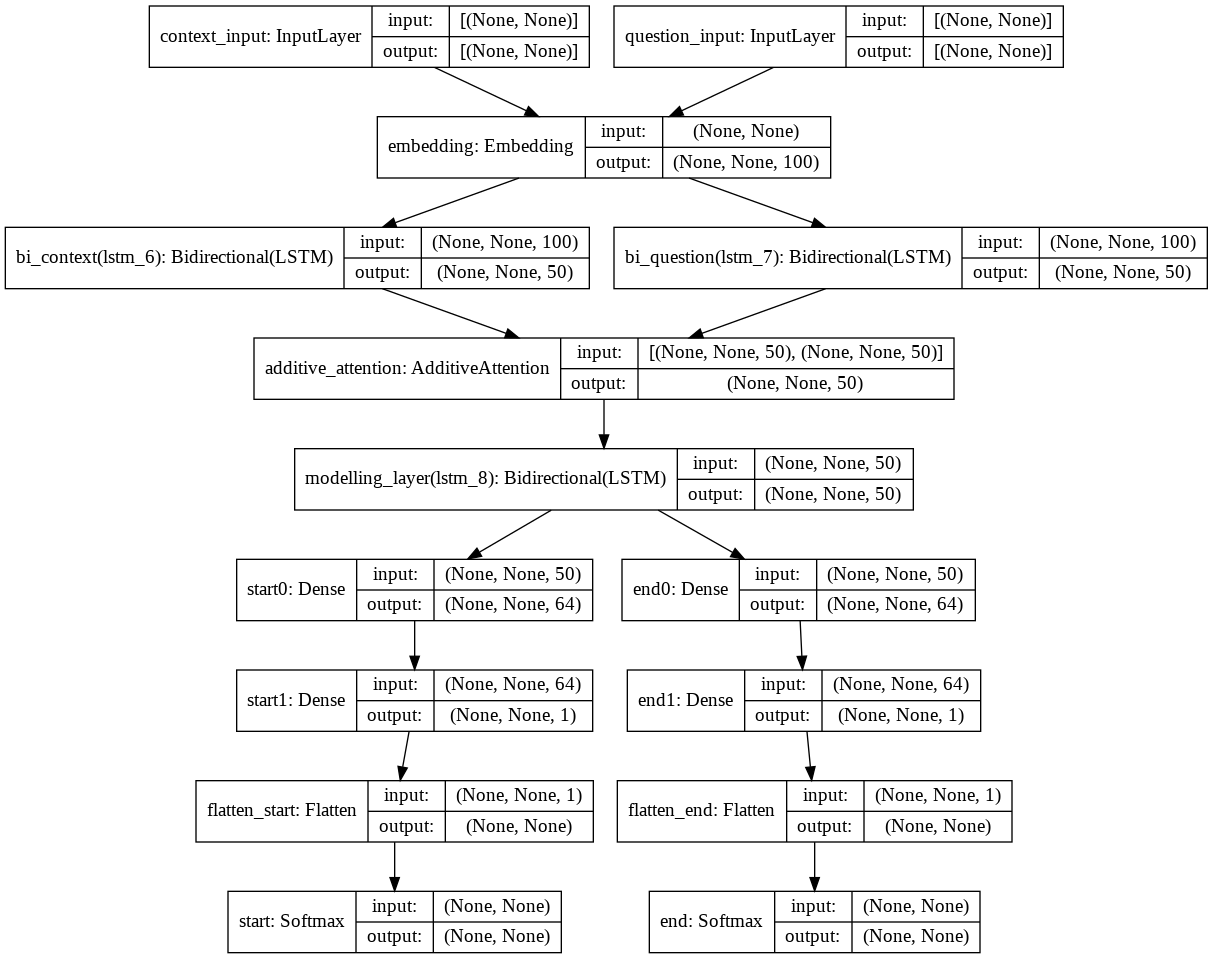

In [ ]:
model = build_model(rnn_units, lrn_rate)
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
context_input (InputLayer)      [(None, None)]       0                                            
__________________________________________________________________________________________________
question_input (InputLayer)     [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 100)    7861700     context_input[0][0]              
                                                                 question_input[0][0]             
__________________________________________________________________________________________________
bi_context (Bidirectional)      (None, None, 50)     60400       embedding[4][0]            

###TRAIN

Epoch 1/100
255/255 [==============================] - 64s 224ms/step - loss: 9.9078 - start_loss: 5.8750 - end_loss: 4.0328 - start_categorical_accuracy: 0.0259 - end_categorical_accuracy: 0.0955 - val_loss: 9.0339 - val_start_loss: 6.0661 - val_end_loss: 2.9678 - val_start_categorical_accuracy: 0.0329 - val_end_categorical_accuracy: 0.2209

Epoch 00001: val_loss improved from inf to 9.03386, saving model to ./models/models/model1_additiveattention.h5
Epoch 2/100
255/255 [==============================] - 55s 216ms/step - loss: 8.7860 - start_loss: 5.8729 - end_loss: 2.9131 - start_categorical_accuracy: 0.0264 - end_categorical_accuracy: 0.2312 - val_loss: 8.8573 - val_start_loss: 6.0661 - val_end_loss: 2.7911 - val_start_categorical_accuracy: 0.0329 - val_end_categorical_accuracy: 0.2562

Epoch 00002: val_loss improved from 9.03386 to 8.85725, saving model to ./models/models/model1_additiveattention.h5
Epoch 3/100
255/255 [==============================] - 55s 216ms/step - loss: 8.58

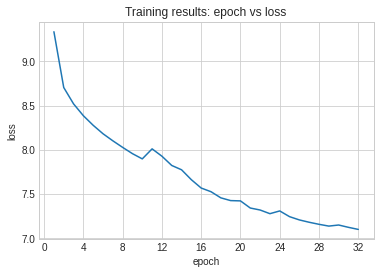

<Figure size 432x288 with 0 Axes>

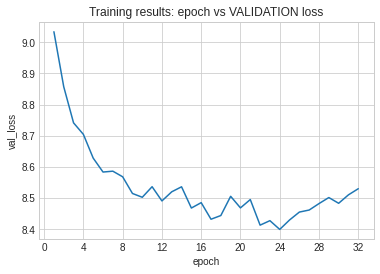

<Figure size 432x288 with 0 Axes>

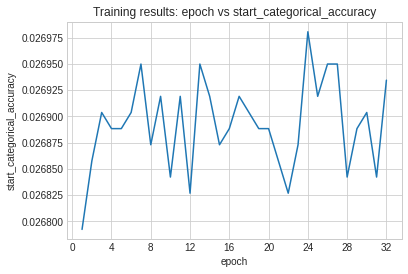

<Figure size 432x288 with 0 Axes>

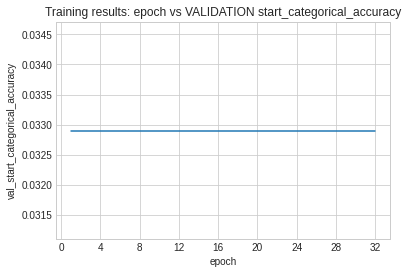

<Figure size 432x288 with 0 Axes>

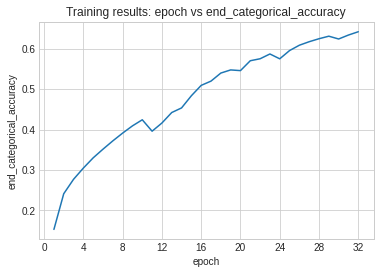

<Figure size 432x288 with 0 Axes>

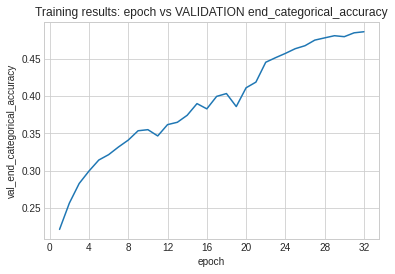

<Figure size 432x288 with 0 Axes>

In [ ]:
model_name = "model1_additiveattention"

history = train_model(folder="./models", model=model, model_name=model_name,
                            train_data=load_data(df_train, btch_size), val_data=df_valENC, batch=btch_size, epochs=n_epochs)

###SAVING MODEL

In [ ]:
model_file = os.path.join('./models/models', model_name+'.h5')
model_bestweights = tf.keras.models.load_model(model_file)

names_to_models1[model_name] = (model_bestweights, history.history)

##MODEL1 : CONSIDERATIONS

In [ ]:
accuracies1 = {}

for key in names_to_models1.keys():
  val_start_categorical_accuracy = names_to_models1[key][1]['val_start_categorical_accuracy'][np.argmin(names_to_models1[key][1]['val_loss'])]
  print(key, "- val_start_categorical_accuracy :")
  print(names_to_models1[key][1]['val_start_categorical_accuracy'][np.argmin(names_to_models1[key][1]['val_loss'])])
  
  val_end_categorical_accuracy = names_to_models1[key][1]['val_end_categorical_accuracy'][np.argmin(names_to_models1[key][1]['val_loss'])]
  print(key, "- val_end_categorical_accuracy :")
  print(names_to_models1[key][1]['val_end_categorical_accuracy'][np.argmin(names_to_models1[key][1]['val_loss'])])
  print()

  mean = (val_start_categorical_accuracy+val_end_categorical_accuracy)/2

  accuracies1[key] = (val_start_categorical_accuracy, val_end_categorical_accuracy, mean)


print("best model in val_start_categorical_accuracy is {} : {}".format(list(accuracies1.keys())[np.argmax([el[0] for el in accuracies1.values()])], max([el[0] for el in accuracies1.values()])))
print("best model in val_end_categorical_accuracy is {} : {}".format(list(accuracies1.keys())[np.argmax([el[1] for el in accuracies1.values()])], max([el[1] for el in accuracies1.values()])))

print("best model overall is {} : {}".format(list(accuracies1.keys())[np.argmax([el[2] for el in accuracies1.values()])], max([el[2] for el in accuracies1.values()])))

model1_attention - val_start_categorical_accuracy :
0.3670681416988373
model1_attention - val_end_categorical_accuracy :
0.4037668704986572

model1_multiheadattention - val_start_categorical_accuracy :
0.24145178496837616
model1_multiheadattention - val_end_categorical_accuracy :
0.2707946002483368

model1_additiveattention - val_start_categorical_accuracy :
0.03289952129125595
model1_additiveattention - val_end_categorical_accuracy :
0.45727911591529846

best model in val_start_categorical_accuracy is model1_attention : 0.3670681416988373
best model in val_end_categorical_accuracy is model1_additiveattention : 0.45727911591529846
best model overall is model1_attention : 0.38541750609874725


#MODEL2 variations - fixed learning rate
MODELS SPECIAL CHARACTERISTICS:
- FIXED LEARNING RATE
- EMBEDDING DIMENSION 100
- BATCH SIZE 256

##MODEL2 : TRAIN FUNCTION

In [ ]:
import shutil

# NAMES OF THE METRICS FOR TRAIN SET (as they are) AND VALIDATION SET (with a the prefix "val_"):
    #loss
    #start_loss
    #end_loss
    #start_categorical_accuracy
    #end_categorical_accuracy

def train_model(folder, model, model_name, train_data, val_data, batch, epochs):
  
  # Path where the final model will be saved
  models_dir = os.path.join(folder, 'models')
  os.makedirs(models_dir, exist_ok = True)
  model_file = os.path.join(models_dir, model_name+".h5")
  
  # Path where the logs will be saved
  logs_dir = os.path.join('./logs', model_name)
  shutil.rmtree(logs_dir, ignore_errors=True)
  os.makedirs(logs_dir, exist_ok = True) 

  log_file = os.path.join(logs_dir, "training_logs.csv")
  
  # Plot the model structure
  model_image_file = os.path.join(logs_dir, model_name+'.png')
  tf.keras.utils.plot_model(model, to_file=model_image_file, show_shapes=True, show_layer_names=True)

  model_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=model_file,
    save_weights_only=False,
    save_best_only=True,
    monitor='val_loss', 
    mode='auto', 
    verbose=1, 
    )
  
  early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    restore_best_weights=True, 
    patience=8,
    monitor='val_loss',
    mode='auto', 
    verbose=1
    )
  
  reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
      monitor='val_loss',
      mode='auto',
      factor=0.5,
      patience=2,
      min_lr=0.001,
      verbose=1
      )
 
  history = model.fit(train_data,
    validation_data=val_data,
    epochs=epochs,
    steps_per_epoch = len(df_train)//batch,
    callbacks=[model_callback, early_stopping_callback]
    )

  draw_graphs(history.history, logs_dir)

  return history

## MODEL2 : ATTENTION

###BUILD

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Bidirectional, Attention, Flatten, Softmax

def build_model(rnn_units, learning_rate):
  # CONTEXT
  context_inputs = Input(shape=(None,), name='context_input')
  embedded_contexts = embedding_layer(context_inputs)
  bi_context = Bidirectional(LSTM(rnn_units, return_sequences=True), name='bi_context', merge_mode = 'sum')
  context_emb = bi_context(embedded_contexts)

  # QUESTION
  question_inputs = Input(shape=(None,), name='question_input')
  embedded_questions = embedding_layer(question_inputs)
  bi_question = Bidirectional(LSTM(rnn_units, return_sequences = True), name='bi_question', merge_mode = 'sum')
  question_emb = bi_question(embedded_questions)

  # ATTENTION
  att = Attention()([context_emb, question_emb])
  
  # FURTHER ELABORATION
  modelling_layer = Bidirectional(LSTM(rnn_units, return_sequences=True), name='modelling_layer', merge_mode = 'sum')(att)

  # START
  start = Dense(64, activation='relu', name='start0')(modelling_layer)
  start = Dense(1, activation='relu', name='start1')(start)
  start = Flatten(name='flatten_start')(start)
  out_start = Softmax(name='start')(start)

  # END
  end = Dense(64, activation='relu', name='end0')(modelling_layer)
  end = Dense(1, activation='relu', name='end1')(end)
  end = Flatten(name='flatten_end')(end)
  out_end = Softmax(name='end')(end)

  # LOSS FUNCTION, ACCURACY and OPTIMIZER DEFINITION
  loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False, name='categorical_crossentropy')
  accuracy = tf.keras.metrics.CategoricalAccuracy(name='categorical_accuracy', dtype=None)
  
  model = Model([question_inputs, context_inputs], [out_start, out_end])
  model.compile(optimizer='Adam', loss=loss, metrics=accuracy) #default learning rate: 0.001

  return model

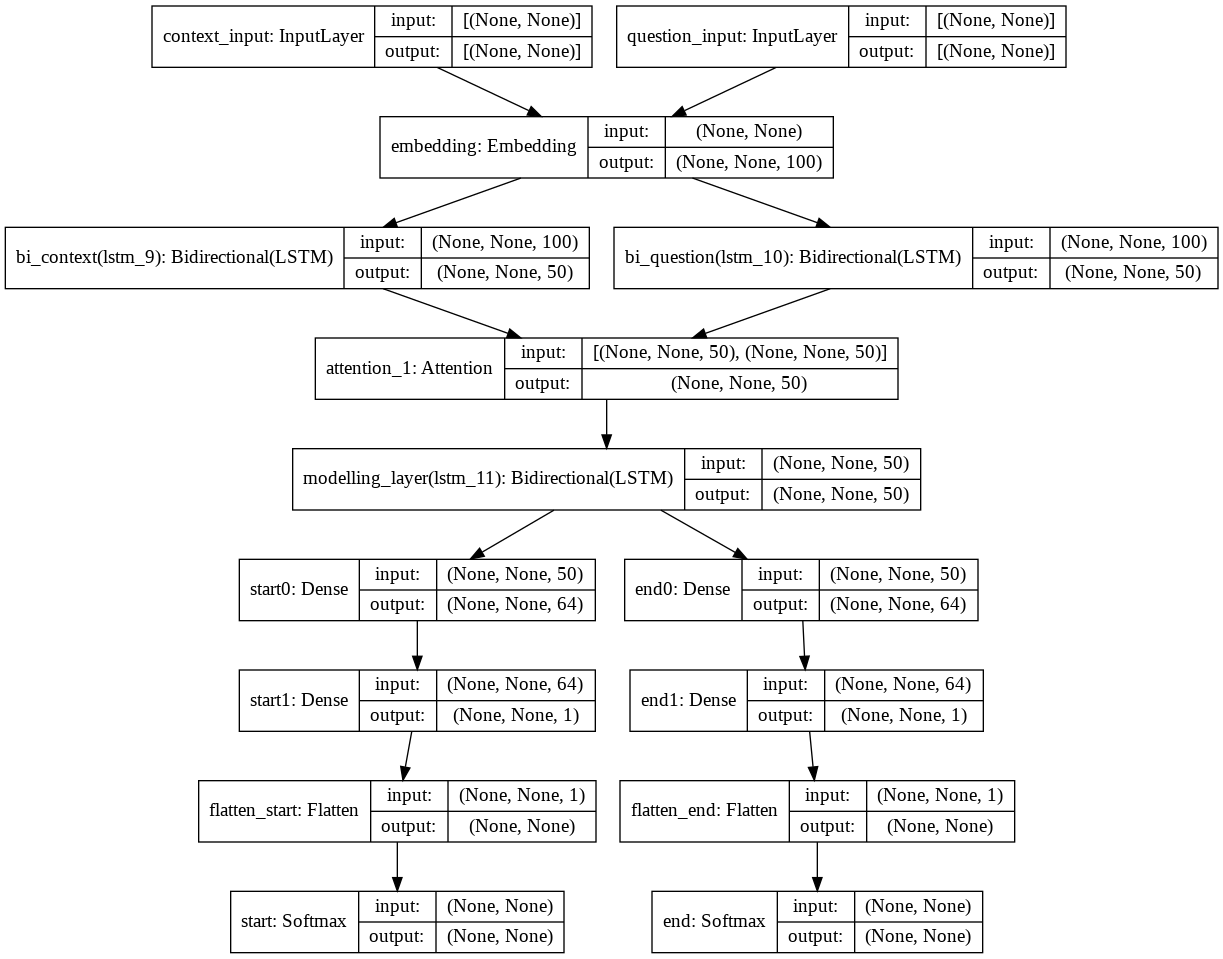

In [ ]:
model = build_model(rnn_units, lrn_rate)
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
context_input (InputLayer)      [(None, None)]       0                                            
__________________________________________________________________________________________________
question_input (InputLayer)     [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 100)    7861700     context_input[0][0]              
                                                                 question_input[0][0]             
__________________________________________________________________________________________________
bi_context (Bidirectional)      (None, None, 50)     60400       embedding[6][0]            

###TRAIN

Epoch 1/100
255/255 [==============================] - 55s 190ms/step - loss: 10.5399 - start_loss: 5.8748 - end_loss: 4.6651 - start_categorical_accuracy: 0.0265 - end_categorical_accuracy: 0.0361 - val_loss: 9.3731 - val_start_loss: 6.0661 - val_end_loss: 3.3069 - val_start_categorical_accuracy: 0.0329 - val_end_categorical_accuracy: 0.1643

Epoch 00001: val_loss improved from inf to 9.37306, saving model to ./models/models/model2_attention.h5
Epoch 2/100
255/255 [==============================] - 47s 185ms/step - loss: 9.1004 - start_loss: 5.8729 - end_loss: 3.2276 - start_categorical_accuracy: 0.0264 - end_categorical_accuracy: 0.1772 - val_loss: 9.0856 - val_start_loss: 6.0661 - val_end_loss: 3.0195 - val_start_categorical_accuracy: 0.0329 - val_end_categorical_accuracy: 0.2154

Epoch 00002: val_loss improved from 9.37306 to 9.08557, saving model to ./models/models/model2_attention.h5
Epoch 3/100
255/255 [==============================] - 47s 184ms/step - loss: 8.8301 - start_loss

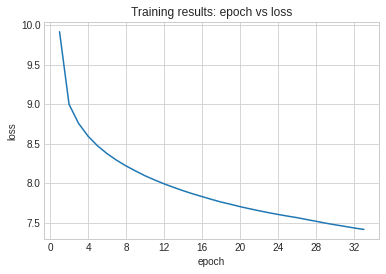

<Figure size 432x288 with 0 Axes>

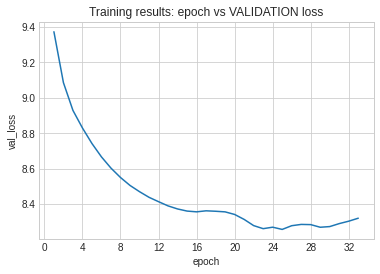

<Figure size 432x288 with 0 Axes>

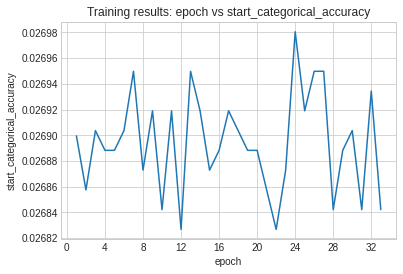

<Figure size 432x288 with 0 Axes>

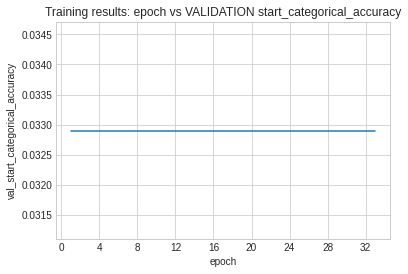

<Figure size 432x288 with 0 Axes>

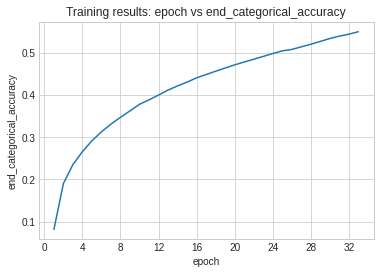

<Figure size 432x288 with 0 Axes>

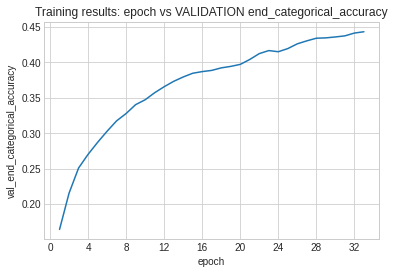

<Figure size 432x288 with 0 Axes>

In [ ]:
model_name = "model2_attention"

history = train_model(folder="./models", model=model, model_name=model_name,
                            train_data=load_data(df_train, btch_size), val_data=df_valENC, batch=btch_size, epochs=n_epochs)

###SAVING MODEL

In [ ]:
names_to_models2 = {}

In [ ]:
model_file = os.path.join('./models/models', model_name+'.h5')
model_bestweights = tf.keras.models.load_model(model_file)

names_to_models2[model_name] = (model_bestweights, history.history)

## MODEL2 : MULTIHEAD ATTENTION

###BUILD

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Bidirectional, Attention, Flatten, Softmax

def build_model(rnn_units, learning_rate):
  # CONTEXT
  context_inputs = Input(shape=(None,), name='context_input')
  embedded_contexts = embedding_layer(context_inputs)
  bi_context = Bidirectional(LSTM(rnn_units, return_sequences=True), name='bi_context', merge_mode = 'sum')
  context_emb = bi_context(embedded_contexts)

  # QUESTION
  question_inputs = Input(shape=(None,), name='question_input')
  embedded_questions = embedding_layer(question_inputs)
  bi_question = Bidirectional(LSTM(rnn_units, return_sequences = True), name='bi_question', merge_mode = 'sum')
  question_emb = bi_question(embedded_questions)

  # MULTIHEAD ATTENTION
  att = tf.keras.layers.MultiHeadAttention(4, key_dim=1,)(query=context_emb, value=question_emb, return_attention_scores=False)

  # FURTHER ELABORATION
  modelling_layer = Bidirectional(LSTM(rnn_units, return_sequences=True), name='modelling_layer', merge_mode = 'sum')(att)

  # START
  start = Dense(64, activation='relu', name='start0')(modelling_layer)
  start = Dense(1, activation='relu', name='start1')(start)
  start = Flatten(name='flatten_start')(start)
  out_start = Softmax(name='start')(start)

  # END
  end = Dense(64, activation='relu', name='end0')(modelling_layer)
  end = Dense(1, activation='relu', name='end1')(end)
  end = Flatten(name='flatten_end')(end)
  out_end = Softmax(name='end')(end)

  # LOSS FUNCTION, ACCURACY and OPTIMIZER DEFINITION
  loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False, name='categorical_crossentropy')
  accuracy = tf.keras.metrics.CategoricalAccuracy(name='categorical_accuracy', dtype=None)
  
  model = Model([question_inputs, context_inputs], [out_start, out_end])
  model.compile(optimizer='Adam', loss=loss, metrics=accuracy) #default learning rate: 0.001

  return model

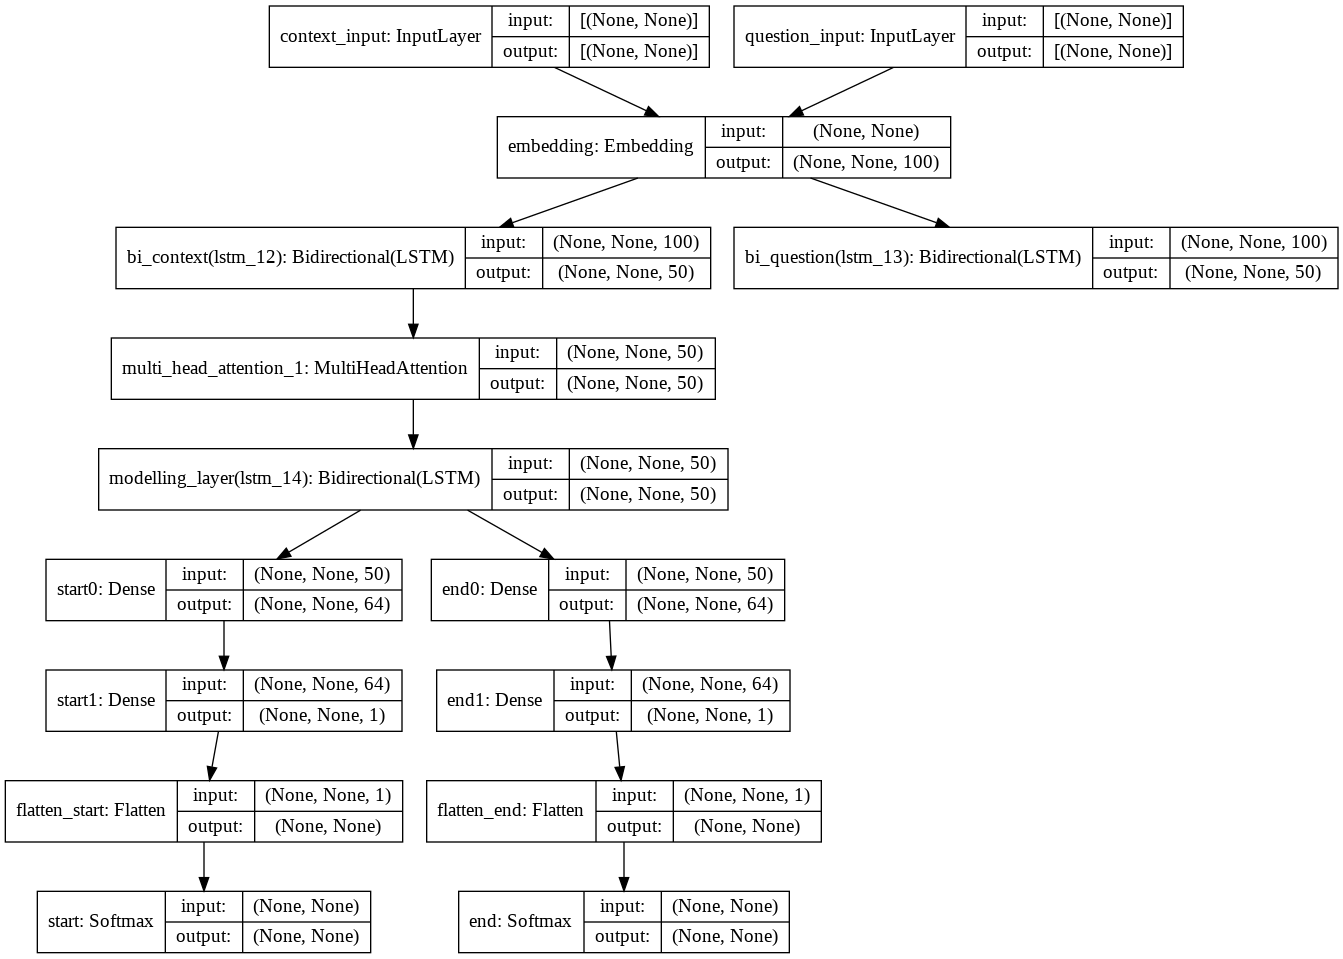

In [ ]:
model = build_model(rnn_units, lrn_rate)
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
context_input (InputLayer)      [(None, None)]       0                                            
__________________________________________________________________________________________________
question_input (InputLayer)     [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 100)    7861700     context_input[0][0]              
                                                                 question_input[0][0]             
__________________________________________________________________________________________________
bi_context (Bidirectional)      (None, None, 50)     60400       embedding[8][0]            

###TRAIN

Epoch 1/100
255/255 [==============================] - 56s 194ms/step - loss: 10.6809 - start_loss: 4.8062 - end_loss: 5.8747 - start_categorical_accuracy: 0.0400 - end_categorical_accuracy: 0.0077 - val_loss: 9.9963 - val_start_loss: 3.9302 - val_end_loss: 6.0661 - val_start_categorical_accuracy: 0.0925 - val_end_categorical_accuracy: 0.0087

Epoch 00001: val_loss improved from inf to 9.99631, saving model to ./models/models/model2_multiheadattention.h5
Epoch 2/100
255/255 [==============================] - 48s 188ms/step - loss: 9.6972 - start_loss: 3.8243 - end_loss: 5.8729 - start_categorical_accuracy: 0.0975 - end_categorical_accuracy: 0.0077 - val_loss: 9.7896 - val_start_loss: 3.7235 - val_end_loss: 6.0661 - val_start_categorical_accuracy: 0.1209 - val_end_categorical_accuracy: 0.0087

Epoch 00002: val_loss improved from 9.99631 to 9.78964, saving model to ./models/models/model2_multiheadattention.h5
Epoch 3/100
255/255 [==============================] - 48s 187ms/step - loss: 9

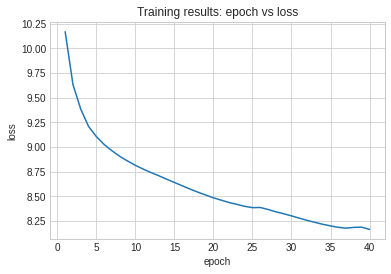

<Figure size 432x288 with 0 Axes>

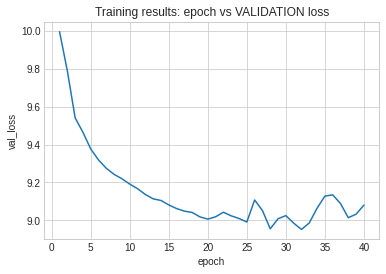

<Figure size 432x288 with 0 Axes>

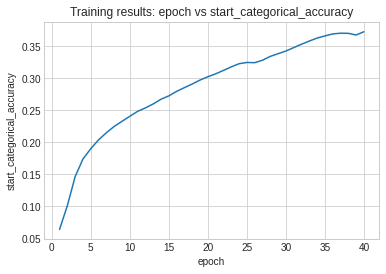

<Figure size 432x288 with 0 Axes>

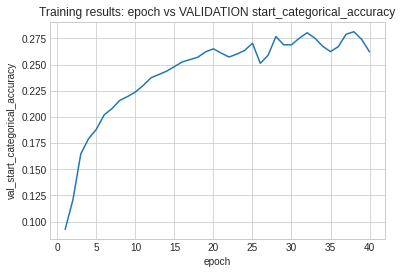

<Figure size 432x288 with 0 Axes>

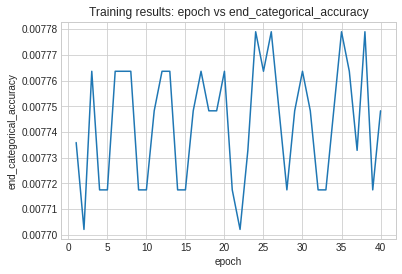

<Figure size 432x288 with 0 Axes>

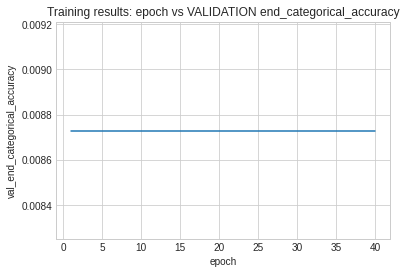

<Figure size 432x288 with 0 Axes>

In [ ]:
model_name = "model2_multiheadattention"

history = train_model(folder="./models", model=model, model_name=model_name,
                            train_data=load_data(df_train, btch_size), val_data=df_valENC, batch=btch_size, epochs=n_epochs)

###SAVING MODEL

In [ ]:
model_file = os.path.join('./models/models', model_name+'.h5')
model_bestweights = tf.keras.models.load_model(model_file)

names_to_models2[model_name] = (model_bestweights, history.history)

## MODEL2 : ADDITIVE ATTENTION

###BUILD

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Bidirectional, Attention, Flatten, Softmax

def build_model(rnn_units, learning_rate):
  # CONTEXT
  context_inputs = Input(shape=(None,), name='context_input')
  embedded_contexts = embedding_layer(context_inputs)
  bi_context = Bidirectional(LSTM(rnn_units, return_sequences=True), name='bi_context', merge_mode = 'sum')
  context_emb = bi_context(embedded_contexts)

  # QUESTION
  question_inputs = Input(shape=(None,), name='question_input')
  embedded_questions = embedding_layer(question_inputs)
  bi_question = Bidirectional(LSTM(rnn_units, return_sequences = True), name='bi_question', merge_mode = 'sum')
  question_emb = bi_question(embedded_questions)

  # ADDITIVE ATTENTION
  att = AdditiveAttention()([context_emb, question_emb])

  # FURTHER ELABORATION
  modelling_layer = Bidirectional(LSTM(rnn_units, return_sequences=True), name='modelling_layer', merge_mode = 'sum')(att)

  # START
  start = Dense(64, activation='relu', name='start0')(modelling_layer)
  start = Dense(1, activation='relu', name='start1')(start)
  start = Flatten(name='flatten_start')(start)
  out_start = Softmax(name='start')(start)

  # END
  end = Dense(64, activation='relu', name='end0')(modelling_layer)
  end = Dense(1, activation='relu', name='end1')(end)
  end = Flatten(name='flatten_end')(end)
  out_end = Softmax(name='end')(end)

  # LOSS FUNCTION, ACCURACY and OPTIMIZER DEFINITION
  loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False, name='categorical_crossentropy')
  accuracy = tf.keras.metrics.CategoricalAccuracy(name='categorical_accuracy', dtype=None)
  
  model = Model([question_inputs, context_inputs], [out_start, out_end])
  model.compile(optimizer='Adam', loss=loss, metrics=accuracy) #default learning rate: 0.001

  return model

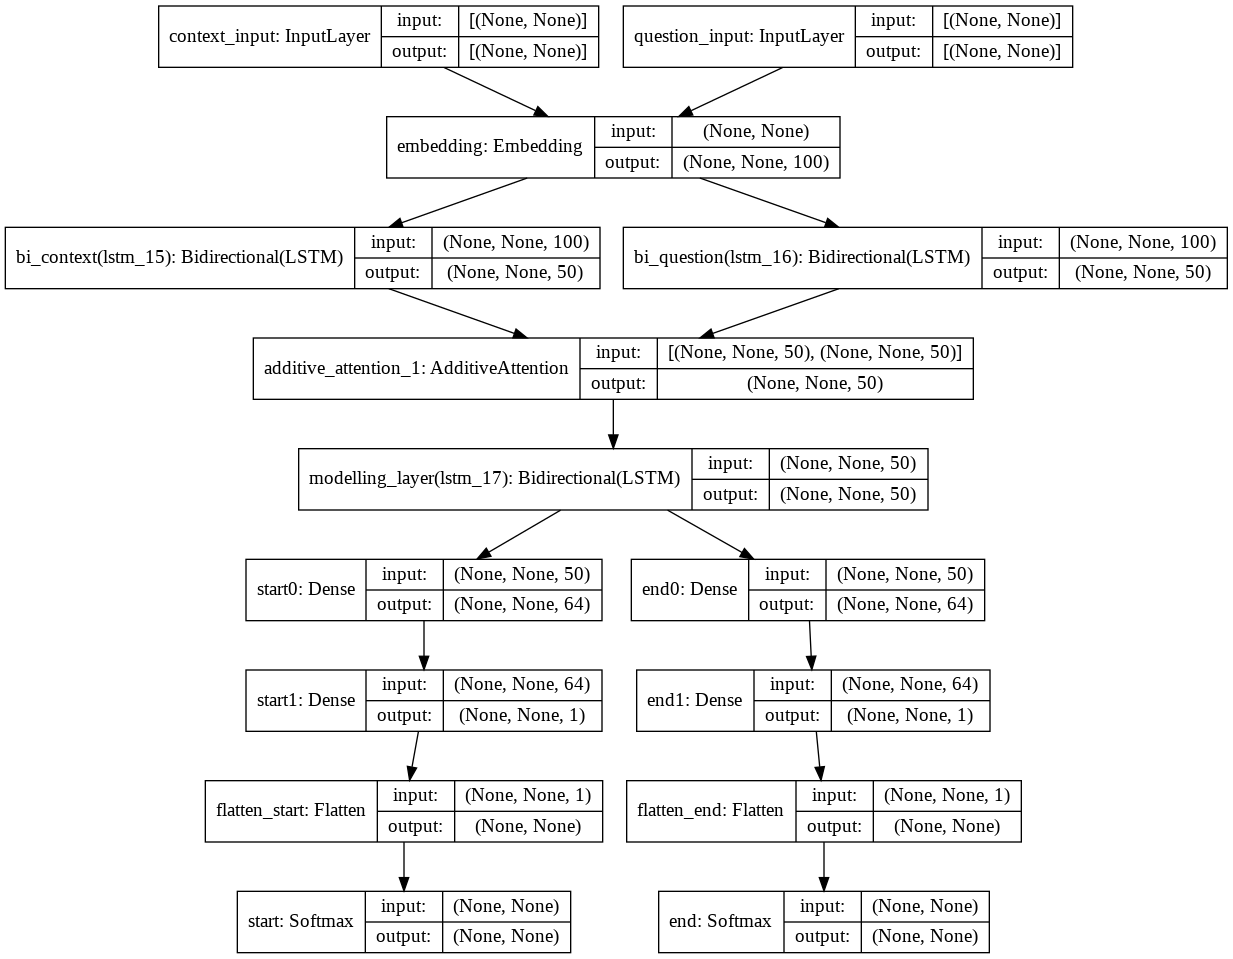

In [ ]:
model = build_model(rnn_units, lrn_rate)
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
context_input (InputLayer)      [(None, None)]       0                                            
__________________________________________________________________________________________________
question_input (InputLayer)     [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 100)    7861700     context_input[0][0]              
                                                                 question_input[0][0]             
__________________________________________________________________________________________________
bi_context (Bidirectional)      (None, None, 50)     60400       embedding[10][0]           

###TRAIN

Epoch 1/100
255/255 [==============================] - 64s 224ms/step - loss: 9.3913 - start_loss: 4.7429 - end_loss: 4.6485 - start_categorical_accuracy: 0.0425 - end_categorical_accuracy: 0.0439 - val_loss: 7.2064 - val_start_loss: 3.7888 - val_end_loss: 3.4177 - val_start_categorical_accuracy: 0.1402 - val_end_categorical_accuracy: 0.1569

Epoch 00001: val_loss improved from inf to 7.20644, saving model to ./models/models/model2_additiveattention.h5
Epoch 2/100
255/255 [==============================] - 55s 218ms/step - loss: 6.9347 - start_loss: 3.6221 - end_loss: 3.3125 - start_categorical_accuracy: 0.1578 - end_categorical_accuracy: 0.1770 - val_loss: 6.5318 - val_start_loss: 3.4364 - val_end_loss: 3.0955 - val_start_categorical_accuracy: 0.1946 - val_end_categorical_accuracy: 0.2118

Epoch 00002: val_loss improved from 7.20644 to 6.53184, saving model to ./models/models/model2_additiveattention.h5
Epoch 3/100
255/255 [==============================] - 55s 217ms/step - loss: 6.34

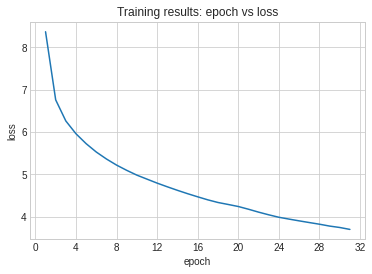

<Figure size 432x288 with 0 Axes>

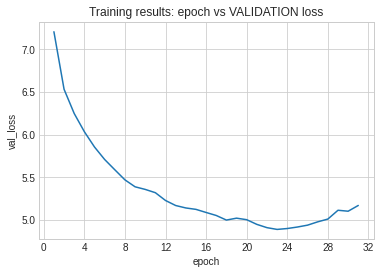

<Figure size 432x288 with 0 Axes>

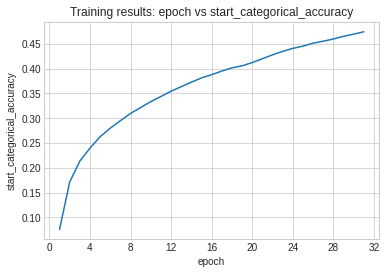

<Figure size 432x288 with 0 Axes>

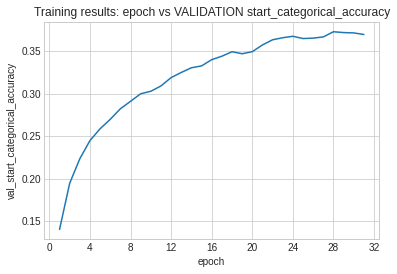

<Figure size 432x288 with 0 Axes>

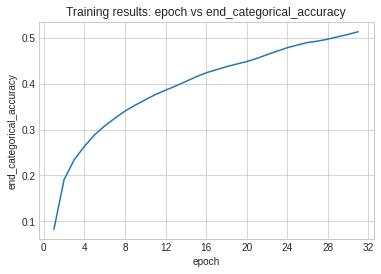

<Figure size 432x288 with 0 Axes>

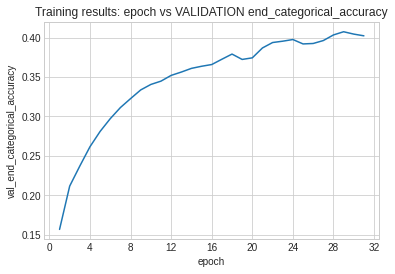

<Figure size 432x288 with 0 Axes>

In [ ]:
model_name = "model2_additiveattention"

history = train_model(folder="./models", model=model, model_name=model_name,
                            train_data=load_data(df_train, btch_size), val_data=df_valENC, batch=btch_size, epochs=n_epochs)

###SAVING MODEL

In [ ]:
model_file = os.path.join('./models/models', model_name+'.h5')
model_bestweights = tf.keras.models.load_model(model_file)

names_to_models2[model_name] = (model_bestweights, history.history)

##MODEL2 : CONSIDERATIONS

In [ ]:
accuracies2 = {}

for key in names_to_models2.keys():
  val_start_categorical_accuracy = names_to_models2[key][1]['val_start_categorical_accuracy'][np.argmin(names_to_models2[key][1]['val_loss'])]
  print(key, "- val_start_categorical_accuracy :")
  print(names_to_models2[key][1]['val_start_categorical_accuracy'][np.argmin(names_to_models2[key][1]['val_loss'])])
  
  val_end_categorical_accuracy = names_to_models2[key][1]['val_end_categorical_accuracy'][np.argmin(names_to_models2[key][1]['val_loss'])]
  print(key, "- val_end_categorical_accuracy :")
  print(names_to_models2[key][1]['val_end_categorical_accuracy'][np.argmin(names_to_models2[key][1]['val_loss'])])
  print()

  mean = (val_start_categorical_accuracy+val_end_categorical_accuracy)/2

  accuracies2[key] = (val_start_categorical_accuracy, val_end_categorical_accuracy, mean)


print("best model in val_start_categorical_accuracy is {} : {}".format(list(accuracies2.keys())[np.argmax([el[0] for el in accuracies2.values()])], max([el[0] for el in accuracies2.values()])))
print("best model in val_end_categorical_accuracy is {} : {}".format(list(accuracies2.keys())[np.argmax([el[1] for el in accuracies2.values()])], max([el[1] for el in accuracies2.values()])))

print("best model overall is {} : {}".format(list(accuracies2.keys())[np.argmax([el[2] for el in accuracies2.values()])], max([el[2] for el in accuracies2.values()])))

model2_attention - val_start_categorical_accuracy :
0.03289952129125595
model2_attention - val_end_categorical_accuracy :
0.4195295572280884

model2_multiheadattention - val_start_categorical_accuracy :
0.2804138660430908
model2_multiheadattention - val_end_categorical_accuracy :
0.008730094879865646

model2_additiveattention - val_start_categorical_accuracy :
0.36569395661354065
model2_additiveattention - val_end_categorical_accuracy :
0.3953601121902466

best model in val_start_categorical_accuracy is model2_additiveattention : 0.36569395661354065
best model in val_end_categorical_accuracy is model2_attention : 0.4195295572280884
best model overall is model2_additiveattention : 0.3805270344018936


#MODEL3 variations - smaller batch size
MODELS SPECIAL CHARACTERISTICS:
- LEARNING RATE: BEST OF THE PREVIOUS
- EMBEDDING DIMENSION 100
- BATCH SIZE 64

## MODEL3 : ADDITIVE ATTENTION + FIXED LEARNING RATE

###PARAMETERS

In [ ]:
#### Parameters : #################

# EMBEDDING DIMENSION
emb_dimension = 100

# BATCH SIZE
btch_size = 64 #choose 2 to the power of 6-9 and fitting the gpu ram

# NUMBER OF EPOCHS
n_epochs = 100

# LEARNING RATE
lrn_rate = 0.001

# RNN UNITS
rnn_units = 50

###################################

###TRAIN FUNCTION

In [ ]:
import shutil

# NAMES OF THE METRICS FOR TRAIN SET (as they are) AND VALIDATION SET (with a the prefix "val_"):
    #loss
    #start_loss
    #end_loss
    #start_categorical_accuracy
    #end_categorical_accuracy

def train_model(folder, model, model_name, train_data, val_data, batch, epochs):
  
  # Path where the final model will be saved
  models_dir = os.path.join(folder, 'models')
  os.makedirs(models_dir, exist_ok = True)
  model_file = os.path.join(models_dir, model_name+".h5")
  
  # Path where the logs will be saved
  logs_dir = os.path.join('./logs', model_name)
  shutil.rmtree(logs_dir, ignore_errors=True)
  os.makedirs(logs_dir, exist_ok = True) 

  log_file = os.path.join(logs_dir, "training_logs.csv")
  
  # Plot the model structure
  model_image_file = os.path.join(logs_dir, model_name+'.png')
  tf.keras.utils.plot_model(model, to_file=model_image_file, show_shapes=True, show_layer_names=True)

  model_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=model_file,
    save_weights_only=False,
    save_best_only=True,
    monitor='val_loss', 
    mode='auto', 
    verbose=1, 
    )
  
  early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    restore_best_weights=True, 
    patience=8,
    monitor='val_loss',
    mode='auto', 
    verbose=1
    )
  
  reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
      monitor='val_loss',
      mode='auto',
      factor=0.5,
      patience=2,
      min_lr=0.001,
      verbose=1
      )
 
  history = model.fit(train_data,
    validation_data=val_data,
    epochs=epochs,
    steps_per_epoch = len(df_train)//batch,
    callbacks=[model_callback, early_stopping_callback]
    )

  draw_graphs(history.history, logs_dir)

  return history

###BUILD

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Bidirectional, Attention, Flatten, Softmax

def build_model(rnn_units, learning_rate):
  # CONTEXT
  context_inputs = Input(shape=(None,), name='context_input')
  embedded_contexts = embedding_layer(context_inputs)
  bi_context = Bidirectional(LSTM(rnn_units, return_sequences=True), name='bi_context', merge_mode = 'sum')
  context_emb = bi_context(embedded_contexts)

  # QUESTION
  question_inputs = Input(shape=(None,), name='question_input')
  embedded_questions = embedding_layer(question_inputs)
  bi_question = Bidirectional(LSTM(rnn_units, return_sequences = True), name='bi_question', merge_mode = 'sum')
  question_emb = bi_question(embedded_questions)

  # ADDITIVE ATTENTION
  att = AdditiveAttention()([context_emb, question_emb])

  # FURTHER ELABORATION
  modelling_layer = Bidirectional(LSTM(rnn_units, return_sequences=True), name='modelling_layer', merge_mode = 'sum')(att)

  # START
  start = Dense(64, activation='relu', name='start0')(modelling_layer)
  start = Dense(1, activation='relu', name='start1')(start)
  start = Flatten(name='flatten_start')(start)
  out_start = Softmax(name='start')(start)

  # END
  end = Dense(64, activation='relu', name='end0')(modelling_layer)
  end = Dense(1, activation='relu', name='end1')(end)
  end = Flatten(name='flatten_end')(end)
  out_end = Softmax(name='end')(end)

  # LOSS FUNCTION, ACCURACY and OPTIMIZER DEFINITION
  loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False, name='categorical_crossentropy')
  accuracy = tf.keras.metrics.CategoricalAccuracy(name='categorical_accuracy', dtype=None)
  
  model = Model([question_inputs, context_inputs], [out_start, out_end])
  model.compile(optimizer='Adam', loss=loss, metrics=accuracy) #default learning rate: 0.001

  return model

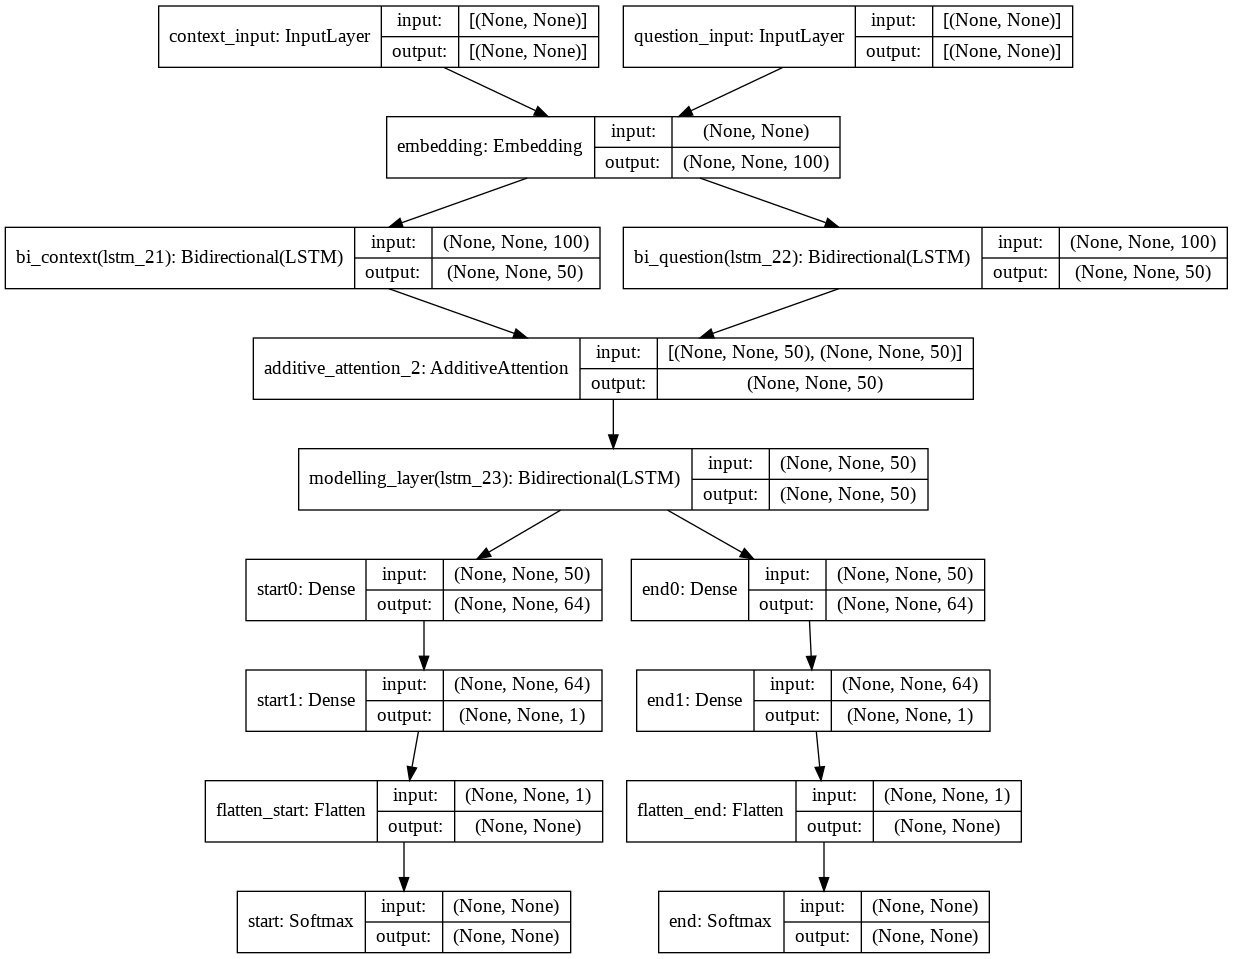

In [ ]:
model = build_model(rnn_units, lrn_rate)
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
context_input (InputLayer)      [(None, None)]       0                                            
__________________________________________________________________________________________________
question_input (InputLayer)     [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 100)    7861700     context_input[0][0]              
                                                                 question_input[0][0]             
__________________________________________________________________________________________________
bi_context (Bidirectional)      (None, None, 50)     60400       embedding[14][0]           

###TRAIN

Epoch 1/100
1020/1020 [==============================] - 101s 91ms/step - loss: 9.7284 - start_loss: 5.6673 - end_loss: 4.0612 - start_categorical_accuracy: 0.0263 - end_categorical_accuracy: 0.0932 - val_loss: 9.1703 - val_start_loss: 6.0661 - val_end_loss: 3.1042 - val_start_categorical_accuracy: 0.0329 - val_end_categorical_accuracy: 0.2050

Epoch 00001: val_loss improved from inf to 9.17034, saving model to ./models/models/model3_additiveattention.h5
Epoch 2/100
1020/1020 [==============================] - 91s 90ms/step - loss: 8.6190 - start_loss: 5.6670 - end_loss: 2.9520 - start_categorical_accuracy: 0.0265 - end_categorical_accuracy: 0.2277 - val_loss: 8.9166 - val_start_loss: 6.0661 - val_end_loss: 2.8505 - val_start_categorical_accuracy: 0.0329 - val_end_categorical_accuracy: 0.2536

Epoch 00002: val_loss improved from 9.17034 to 8.91657, saving model to ./models/models/model3_additiveattention.h5
Epoch 3/100
1020/1020 [==============================] - 91s 90ms/step - loss: 

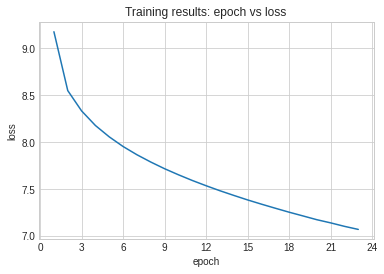

<Figure size 432x288 with 0 Axes>

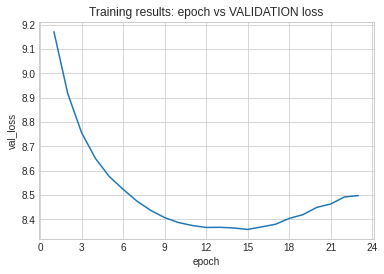

<Figure size 432x288 with 0 Axes>

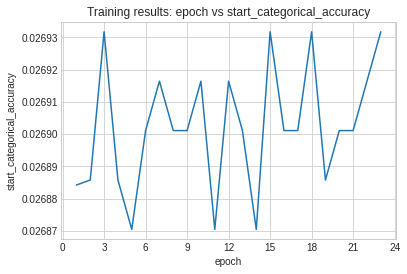

<Figure size 432x288 with 0 Axes>

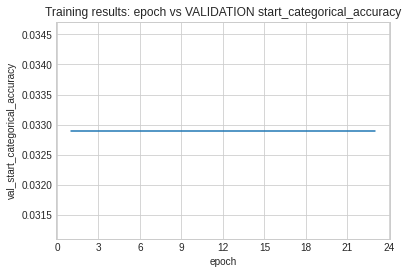

<Figure size 432x288 with 0 Axes>

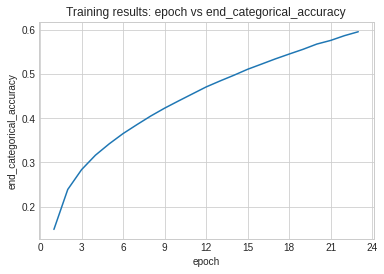

<Figure size 432x288 with 0 Axes>

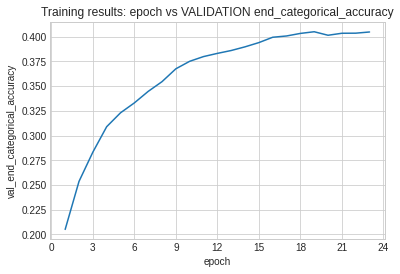

<Figure size 432x288 with 0 Axes>

In [ ]:
model_name = "model3_additiveattention"

history = train_model(folder="./models", model=model, model_name=model_name,
                            train_data=load_data(df_train, btch_size), val_data=df_valENC, batch=btch_size, epochs=n_epochs)

###SAVING MODEL

In [ ]:
names_to_models3 = {}

In [ ]:
model_file = os.path.join('./models/models', model_name+'.h5')
model_bestweights = tf.keras.models.load_model(model_file)

names_to_models3[model_name] = (model_bestweights, history.history)

## MODEL3 : ATTENTION + REDUCIBLE LEARNING RATE

###PARAMETERS

In [ ]:
#### Parameters : #################

# EMBEDDING DIMENSION
emb_dimension = 100

# BATCH SIZE
btch_size = 64 #choose 2 to the power of 6-9 and fitting the gpu ram

# NUMBER OF EPOCHS
n_epochs = 100

# LEARNING RATE
lrn_rate = 0.01

# RNN UNITS
rnn_units = 50

###################################

###TRAIN FUNCTION

In [ ]:
import shutil

# NAMES OF THE METRICS FOR TRAIN SET (as they are) AND VALIDATION SET (with a the prefix "val_"):
    #loss
    #start_loss
    #end_loss
    #start_categorical_accuracy
    #end_categorical_accuracy

def train_model(folder, model, model_name, train_data, val_data, batch, epochs):
  
  # Path where the final model will be saved
  models_dir = os.path.join(folder, 'models')
  os.makedirs(models_dir, exist_ok = True)
  model_file = os.path.join(models_dir, model_name+".h5")
  
  # Path where the logs will be saved
  logs_dir = os.path.join('./logs', model_name)
  shutil.rmtree(logs_dir, ignore_errors=True)
  os.makedirs(logs_dir, exist_ok = True) 

  log_file = os.path.join(logs_dir, "training_logs.csv")
  
  # Plot the model structure
  model_image_file = os.path.join(logs_dir, model_name+'.png')
  tf.keras.utils.plot_model(model, to_file=model_image_file, show_shapes=True, show_layer_names=True)

  model_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=model_file,
    save_weights_only=False,
    save_best_only=True,
    monitor='val_loss', 
    mode='auto', 
    verbose=1, 
    )
  
  early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    restore_best_weights=True, 
    patience=8,
    monitor='val_loss',
    mode='auto', 
    verbose=1
    )
  
  reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
      monitor='val_loss',
      mode='auto',
      factor=0.5,
      patience=2,
      min_lr=0.001,
      verbose=1
      )
 
  history = model.fit(train_data,
    validation_data=val_data,
    epochs=epochs,
    steps_per_epoch = len(df_train)//batch,
    callbacks=[model_callback, early_stopping_callback, reduce_lr_callback]
    )

  draw_graphs(history.history, logs_dir)

  return history

###BUILD

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Bidirectional, Attention, Flatten, Softmax

def build_model(rnn_units, learning_rate):
  # CONTEXT
  context_inputs = Input(shape=(None,), name='context_input')
  embedded_contexts = embedding_layer(context_inputs)
  bi_context = Bidirectional(LSTM(rnn_units, return_sequences=True), name='bi_context', merge_mode = 'sum')
  context_emb = bi_context(embedded_contexts)

  # QUESTION
  question_inputs = Input(shape=(None,), name='question_input')
  embedded_questions = embedding_layer(question_inputs)
  bi_question = Bidirectional(LSTM(rnn_units, return_sequences = True), name='bi_question', merge_mode = 'sum')
  question_emb = bi_question(embedded_questions)

  # ATTENTION
  att = Attention()([context_emb, question_emb])
  
  # FURTHER ELABORATION
  modelling_layer = Bidirectional(LSTM(rnn_units, return_sequences=True), name='modelling_layer', merge_mode = 'sum')(att)

  # START
  start = Dense(64, activation='relu', name='start0')(modelling_layer)
  start = Dense(1, activation='relu', name='start1')(start)
  start = Flatten(name='flatten_start')(start)
  out_start = Softmax(name='start')(start)

  # END
  end = Dense(64, activation='relu', name='end0')(modelling_layer)
  end = Dense(1, activation='relu', name='end1')(end)
  end = Flatten(name='flatten_end')(end)
  out_end = Softmax(name='end')(end)

  # LOSS FUNCTION, ACCURACY and OPTIMIZER DEFINITION
  loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False, name='categorical_crossentropy')
  accuracy = tf.keras.metrics.CategoricalAccuracy(name='categorical_accuracy', dtype=None)
  opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
  
  model = Model([question_inputs, context_inputs], [out_start, out_end])
  model.compile(optimizer=opt, loss=loss, metrics=accuracy)

  return model

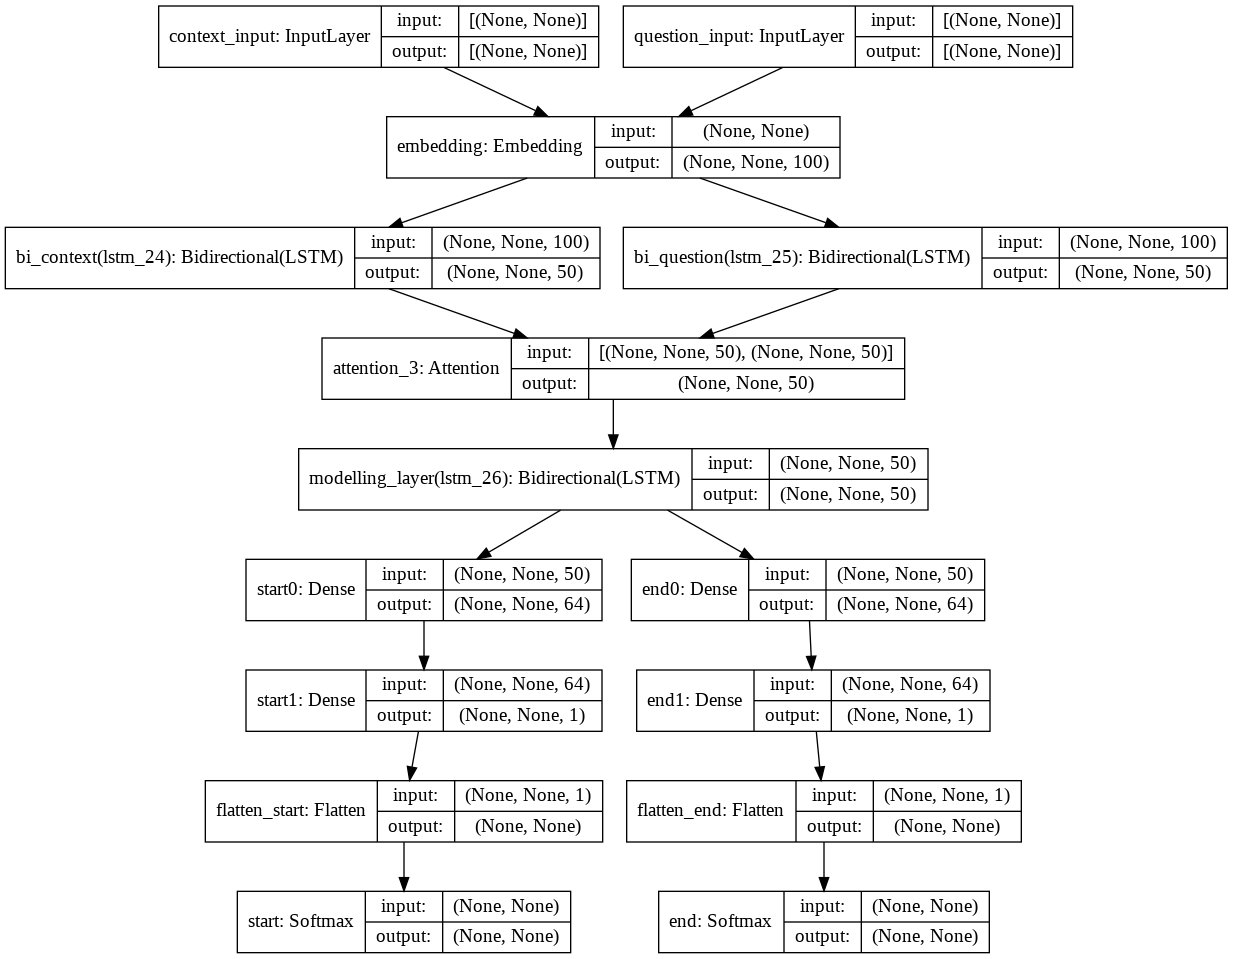

In [ ]:
model = build_model(rnn_units, lrn_rate)
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
context_input (InputLayer)      [(None, None)]       0                                            
__________________________________________________________________________________________________
question_input (InputLayer)     [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 100)    7861700     context_input[0][0]              
                                                                 question_input[0][0]             
__________________________________________________________________________________________________
bi_context (Bidirectional)      (None, None, 50)     60400       embedding[16][0]           

###TRAIN

Epoch 1/100
1020/1020 [==============================] - 94s 85ms/step - loss: 7.3487 - start_loss: 3.7873 - end_loss: 3.5614 - start_categorical_accuracy: 0.1330 - end_categorical_accuracy: 0.1445 - val_loss: 6.2610 - val_start_loss: 3.2874 - val_end_loss: 2.9736 - val_start_categorical_accuracy: 0.2085 - val_end_categorical_accuracy: 0.2249

Epoch 00001: val_loss improved from inf to 6.26103, saving model to ./models/models/model3_attention.h5
Epoch 2/100
1020/1020 [==============================] - 84s 83ms/step - loss: 6.0922 - start_loss: 3.1726 - end_loss: 2.9196 - start_categorical_accuracy: 0.2164 - end_categorical_accuracy: 0.2330 - val_loss: 5.9338 - val_start_loss: 3.1173 - val_end_loss: 2.8165 - val_start_categorical_accuracy: 0.2351 - val_end_categorical_accuracy: 0.2536

Epoch 00002: val_loss improved from 6.26103 to 5.93383, saving model to ./models/models/model3_attention.h5
Epoch 3/100
1020/1020 [==============================] - 85s 83ms/step - loss: 5.7720 - start_lo

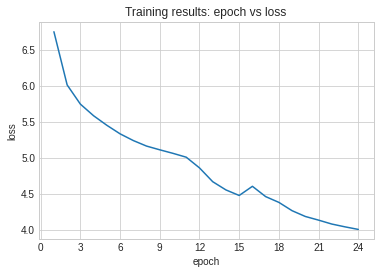

<Figure size 432x288 with 0 Axes>

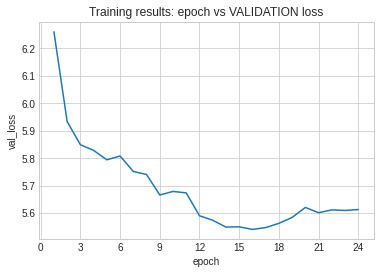

<Figure size 432x288 with 0 Axes>

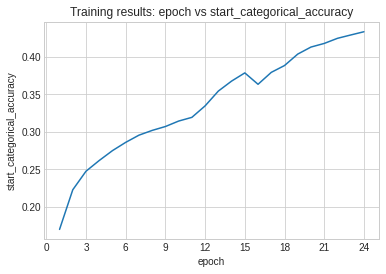

<Figure size 432x288 with 0 Axes>

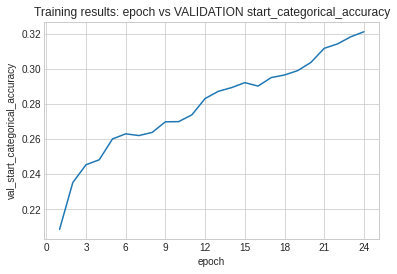

<Figure size 432x288 with 0 Axes>

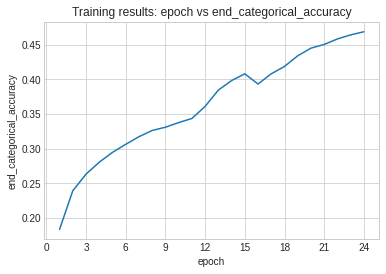

<Figure size 432x288 with 0 Axes>

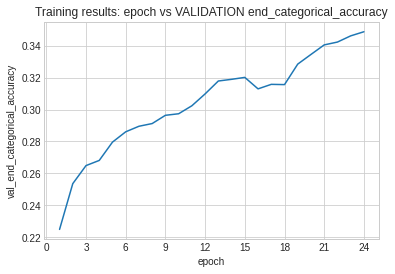

<Figure size 432x288 with 0 Axes>

In [ ]:
model_name = "model3_attention"

history = train_model(folder="./models", model=model, model_name=model_name,
                            train_data=load_data(df_train, btch_size), val_data=df_valENC, batch=btch_size, epochs=n_epochs)

###SAVING MODEL

In [ ]:
model_file = os.path.join('./models/models', model_name+'.h5')
model_bestweights = tf.keras.models.load_model(model_file)

names_to_models3[model_name] = (model_bestweights, history.history)

##MODEL3 : CONSIDERATIONS

In [ ]:
accuracies3 = {}

for key in names_to_models3.keys():
  val_start_categorical_accuracy = names_to_models3[key][1]['val_start_categorical_accuracy'][np.argmin(names_to_models3[key][1]['val_loss'])]
  print(key, "- val_start_categorical_accuracy :")
  print(names_to_models3[key][1]['val_start_categorical_accuracy'][np.argmin(names_to_models3[key][1]['val_loss'])])
  
  val_end_categorical_accuracy = names_to_models3[key][1]['val_end_categorical_accuracy'][np.argmin(names_to_models3[key][1]['val_loss'])]
  print(key, "- val_end_categorical_accuracy :")
  print(names_to_models3[key][1]['val_end_categorical_accuracy'][np.argmin(names_to_models3[key][1]['val_loss'])])
  print()

  mean = (val_start_categorical_accuracy+val_end_categorical_accuracy)/2

  accuracies3[key] = (val_start_categorical_accuracy, val_end_categorical_accuracy, mean)

print("best model in val_start_categorical_accuracy is {} : {}".format(list(accuracies3.keys())[np.argmax([el[0] for el in accuracies3.values()])], max([el[0] for el in accuracies3.values()])))
print("best model in val_end_categorical_accuracy is {} : {}".format(list(accuracies3.keys())[np.argmax([el[1] for el in accuracies3.values()])], max([el[1] for el in accuracies3.values()])))

print("best model overall is {} : {}".format(list(accuracies3.keys())[np.argmax([el[2] for el in accuracies3.values()])], max([el[2] for el in accuracies3.values()])))

model3_additiveattention - val_start_categorical_accuracy :
0.03289952129125595
model3_additiveattention - val_end_categorical_accuracy :
0.39406678080558777

model3_attention - val_start_categorical_accuracy :
0.2901948094367981
model3_attention - val_end_categorical_accuracy :
0.31299006938934326

best model in val_start_categorical_accuracy is model3_attention : 0.2901948094367981
best model in val_end_categorical_accuracy is model3_additiveattention : 0.39406678080558777
best model overall is model3_attention : 0.3015924394130707


#CONCLUSIONS

In [ ]:
print("SUMMING UP :")
print("best model1-type model is {} : {}".format(list(accuracies1.keys())[np.argmax([el[2] for el in accuracies1.values()])], max([el[2] for el in accuracies1.values()])))
print("best model2-type model is {} : {}".format(list(accuracies2.keys())[np.argmax([el[2] for el in accuracies2.values()])], max([el[2] for el in accuracies2.values()])))
print("and model3 is {} : {}".format(list(accuracies3.keys())[np.argmax([el[2] for el in accuracies3.values()])], max([el[2] for el in accuracies3.values()])))

SUMMING UP :
best model1-type model is model1_attention : 0.38541750609874725
best model2-type model is model2_additiveattention : 0.3805270344018936
and model3 is model3_attention : 0.3015924394130707


THEREFORE BEST MODELS OVERALL ARE
- MODEL1 WITH
  - ATTENTION LAYER
  - REDUCIBLE LEARNING RATE (0.01-0.001)
  - BATCH SIZE 256
- MODEL2 WITH
  - ADDITIVE ATTENTION LAYER
  - FIXED SMALL LEARNING RATE (0.001)
  - BATCH SIZE 256